## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

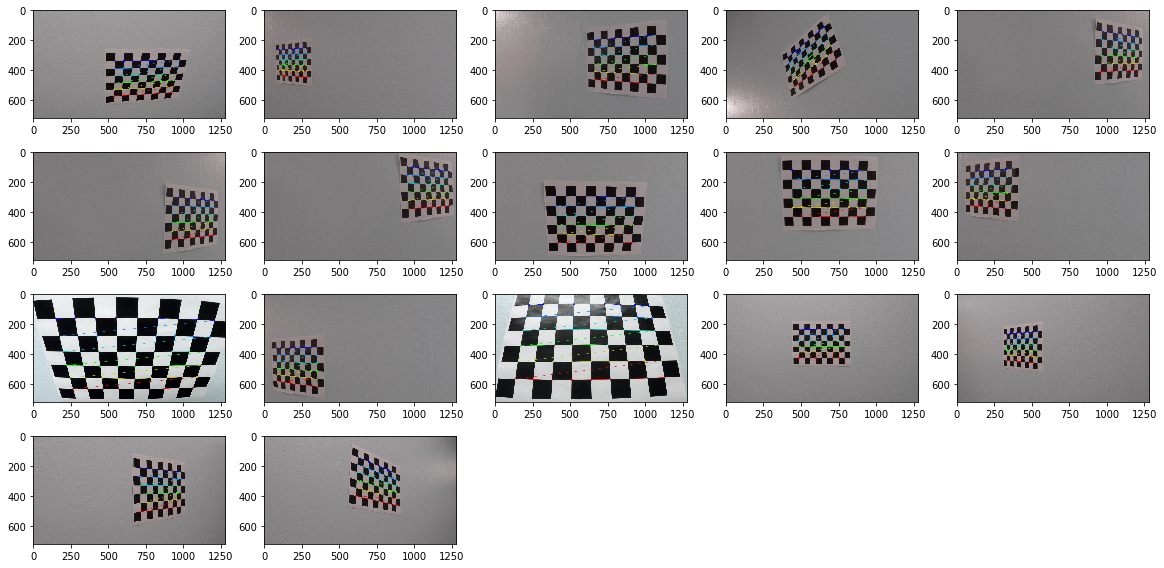

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
file_path = os.getcwd()
file_path = file_path + '/camera_cal/calibration*.jpg'
images = glob.glob(file_path)

plt.figure(figsize=(20,10))
# Step through the list and search for chessboard corners
i=1
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        plt.subplot(4,5,i)
        plt.imshow(img)        
        i=i+1
plt.show()

#cv2.destroyAllWindows()

## Apply a distortion correction to raw images.


In [2]:
def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

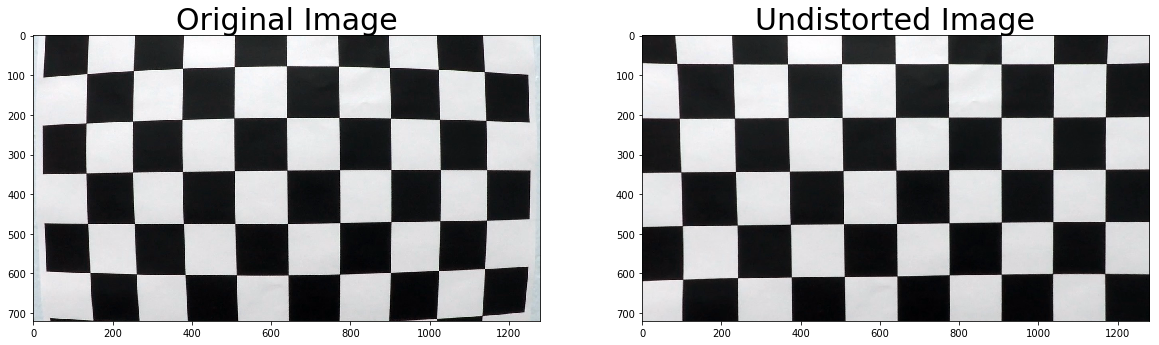

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
file_path = os.getcwd()
file_path = file_path + '/camera_cal/calibration1.jpg'
img = cv2.imread(file_path)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

file_path = os.getcwd()
file_path = file_path + '/output_images/calibration1_undist.jpg'
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(file_path,dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_results.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)

    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [6]:
def S_threshold(img, s_thresh):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    return s_binary

In [7]:
def dir_threshold(img, sobel_kernel=3, abs_thres=(20), dir_thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    abs_sobel = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobel/np.max(abs_sobel))
    abs_sobel = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobel/np.max(abs_sobel))

    sobelx[(scaled_sobelx<abs_thres)] = 0
    sobely[(scaled_sobely<abs_thres)] = 0

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [8]:
def R_threshold(img, r_thresh):
    R = img[:,:,0]
    
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    return r_binary

In [102]:
# Edit this function to create your own pipeline.
def image_threshold(img):
    #img = np.copy(img)

    
    # Sobel x
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary_stack = np.dstack(( 150*np.ones_like(sxbinary), sxbinary, s_binary))
    
    mag_binary = np.uint8(mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255)))
    sobelx_binary = np.uint8(abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=255))
    #sobely_binary = np.uint8(abs_sobel_thresh(img, orient='y', thresh_min=30, thresh_max=255))
    dir_binary = np.uint8(dir_threshold(img, sobel_kernel=15, abs_thres=(20), dir_thresh=(np.pi/2-1,np.pi/2-0.2)))
 
    s_binary = np.uint8(S_threshold(img, s_thresh=(150, 255)))
    r_binary = np.uint8(R_threshold(img, r_thresh=(220, 255)))
    
    ch1_binary = cv2.bitwise_or(s_binary,r_binary)
    ch2_binary = mag_binary = (mag_binary)
    ch3_binary = mag_binary = (dir_binary)
    binary_stack = 255*np.dstack((ch1_binary, ch2_binary, ch3_binary))


    #color_binary_stack = np.array(255*color_binary_stack, dtype = np.float64)
    #s_binary = np.uint8(s_binary)
    #r_binary = np.uint8(r_binary)

    #color_binary = cv2.cvtColor(color_binary_stack,cv2.COLOR_GRAY2RGB)
    binary = np.zeros_like(s_binary)

    binary[(ch1_binary > 0) | (ch2_binary > 0) |(ch3_binary > 0)] = 255

    #color_binary = (binary_stack)
    binary_stack = np.dstack((binary, binary, binary))

    return binary,binary_stack

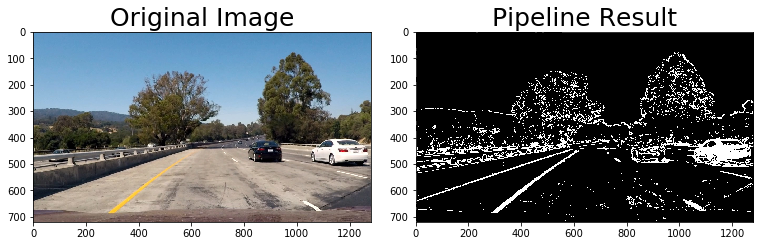

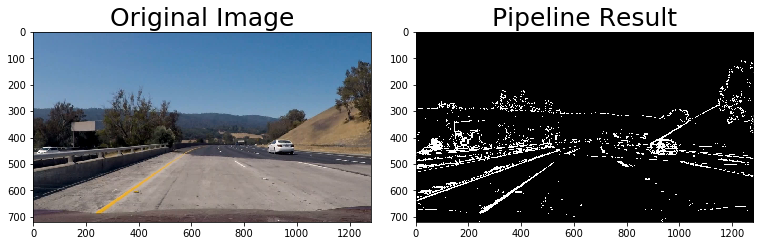

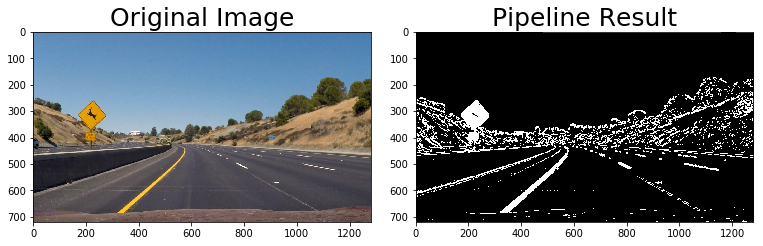

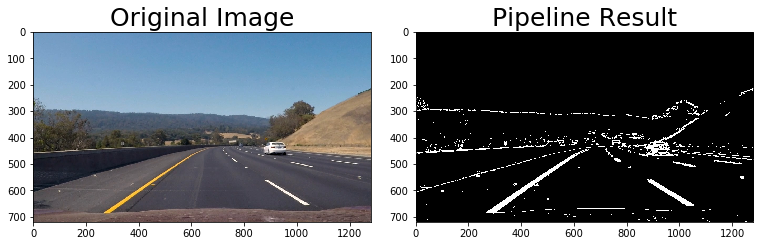

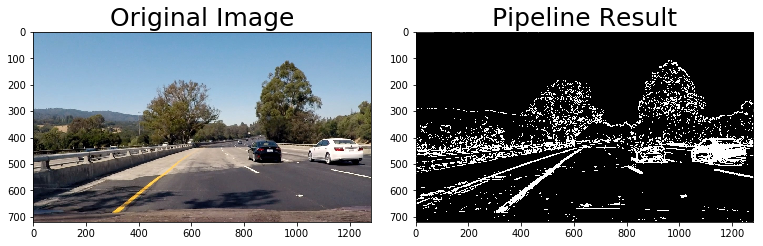

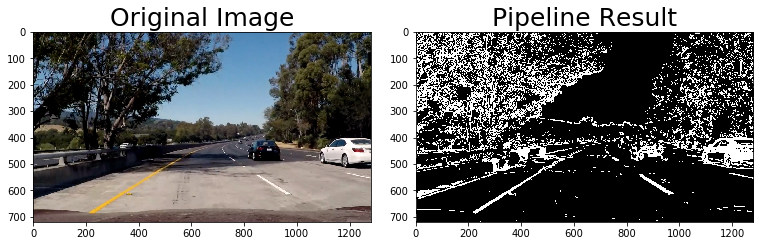

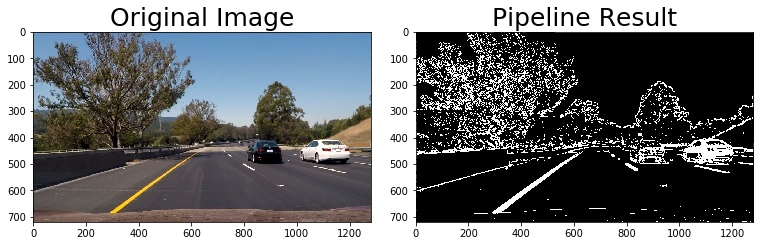

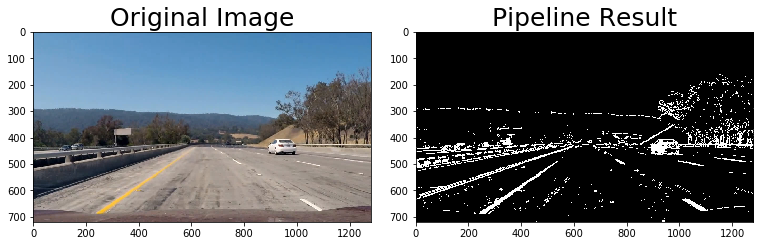

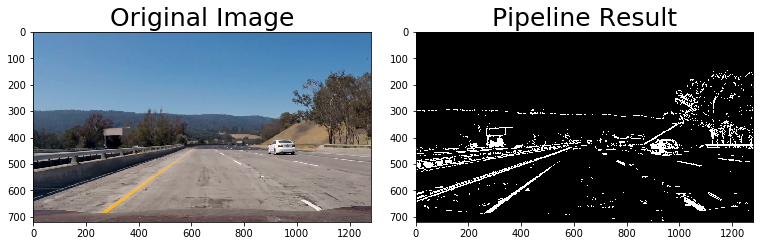

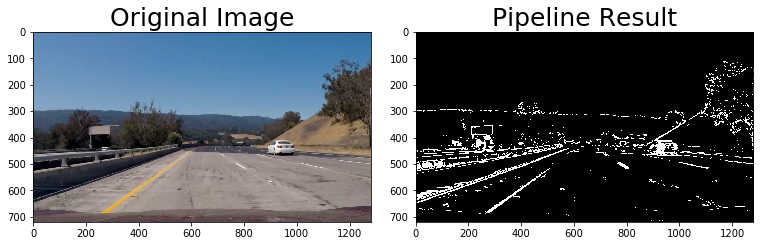

In [103]:
import matplotlib.image as mpimg
# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/test_images/test*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)
    res,result = image_threshold(image)
    
    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'binary' + str(i) + '.jpg'
    cv2.imwrite(file_path,res)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)

    ax2.imshow(result)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [106]:
def image_unwarp(img):
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    
    # 4 destination points dst = np.float32([[,],[,],[,],[,]])
    src = np.float32([[580,450],[770,450],[1130,680],[220,680]])
    src = np.float32([[580,450],[770,450],[1320,680],[30,680]])
    src = np.float32([[650-70,450],[650+70,450],[650+600,680],[650-600,680]])
    src = np.float32([[590,450],[700,450],[1133,680],[200,680]])

    #print(src)

    offset = 100 # offset for dst points
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped,Minv


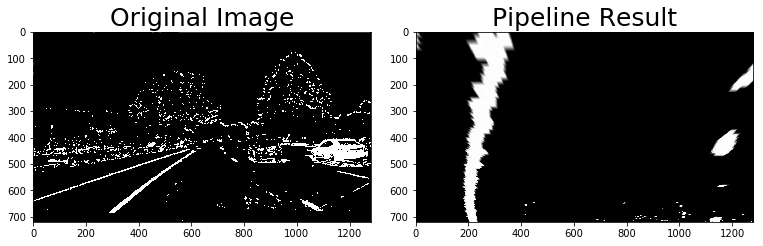

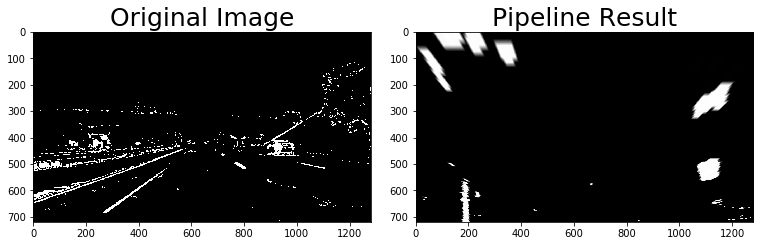

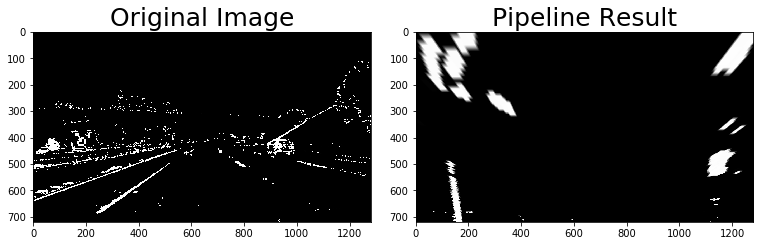

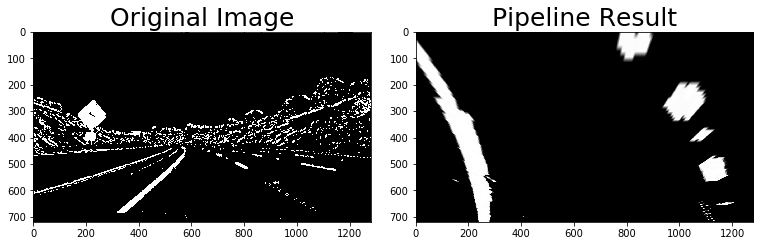

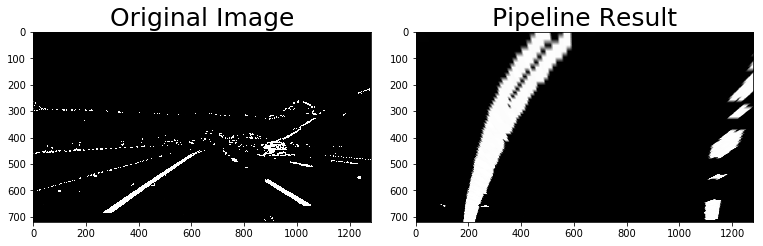

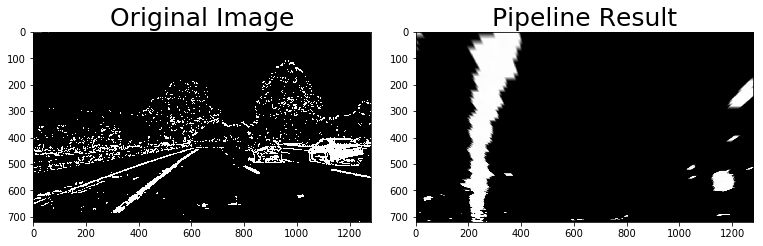

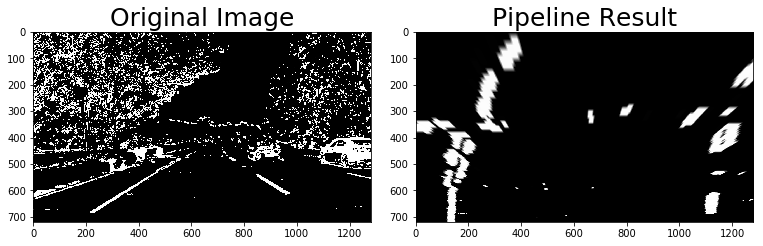

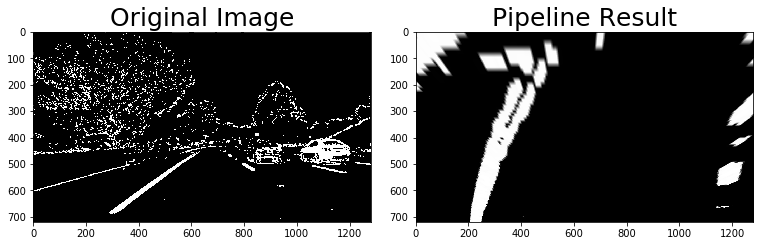

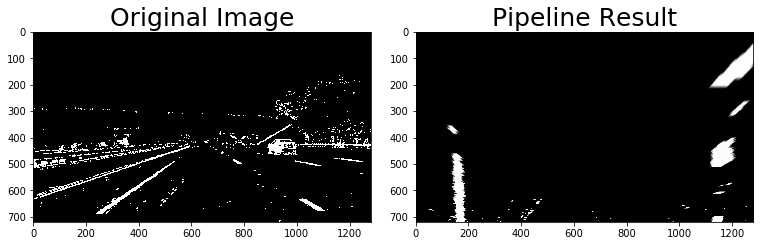

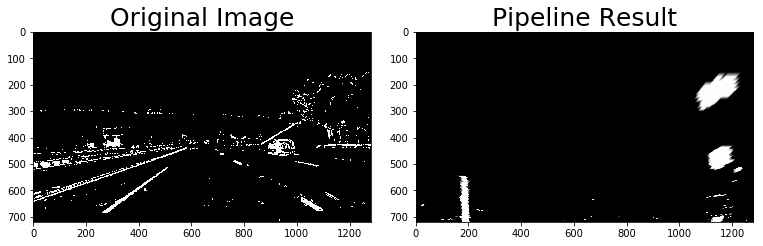

In [118]:
import matplotlib.image as mpimg
# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/output_images/binary*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)
    image = cv2.erode(image, np.ones((3, 3)))
    image = cv2.dilate(image, np.ones((3, 3)))


    top_down,M = image_unwarp(image)

    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'warp' + str(i) + '.jpg'
    cv2.imwrite(file_path,top_down)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    image = np.array(cv2.merge((image,image,image)),np.uint8)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)
    
    top_down = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8)
    ax2.imshow(top_down)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

In [119]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [130]:
def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids

In [139]:
def detect_lanes(warped,n_filter):
    global global_left_fitx
    global global_right_fitx

    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        
        output = cv2.addWeighted(warpage, 0.9, template, 0.5, 0.0) # overlay the orignal road image with window results

        i=0
        left_lane_x=[]
        left_lane_y=[]
        right_lane_x=[]
        right_lane_y=[]
        for centroids in window_centroids:
            left_lane_x.append(centroids[0])
            left_lane_y.append(warped.shape[0]-(i*window_height+window_height/2))
            right_lane_x.append(centroids[1])
            right_lane_y = left_lane_y
            i=i+1
            
        left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
        global_left_fitx.append(left_fit)
        global_left_fitx = global_left_fitx[-n_filter:]
        left_fit = np.median(np.array(global_left_fitx), axis=0)

        right_fit = np.polyfit(right_lane_y, right_lane_x, 2) 
        global_right_fitx.append(right_fit)
        global_right_fitx = global_right_fitx[-n_filter:]
        right_fit = np.median(np.array(global_right_fitx), axis=0) 
 
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        left_fit = np.median(np.array(global_left_fitx), axis=0)
        right_fit = np.median(np.array(global_right_fitx), axis=0)        
        

    
    # Display the final results
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    '''
    print(left_fitx.shape)
    print(right_fitx.shape)
    print(ploty.shape)
    #all_data = np.hstack((left_fitx, ploty),0)
    #all_data = np.append(left_fitx, ploty, 1)
    all_data = np.zeros((left_fitx.shape[0],2))
    all_data[:,0]=left_fitx
    all_data[:,1]=right_fitx

   

    cv2.polylines(output, [all_data], True, (0,255,255), 3)
    cv2.polylines(output, [all_data], True, (255,0,255), 3)
    '''
    return output,ploty,left_fitx,right_fitx

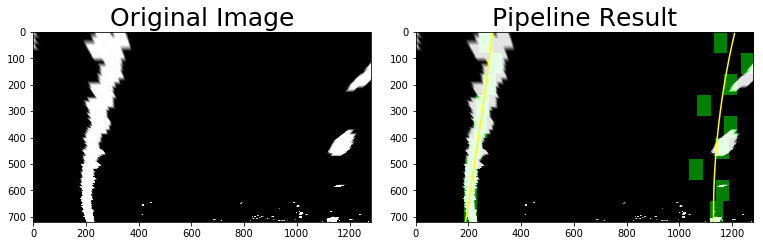

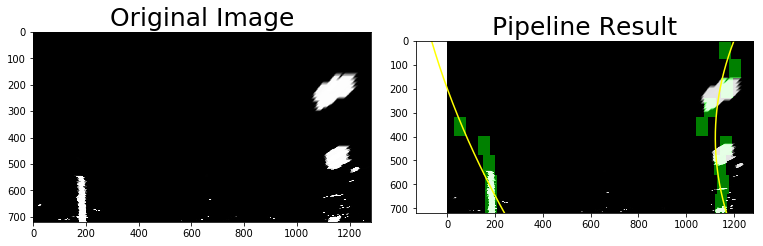

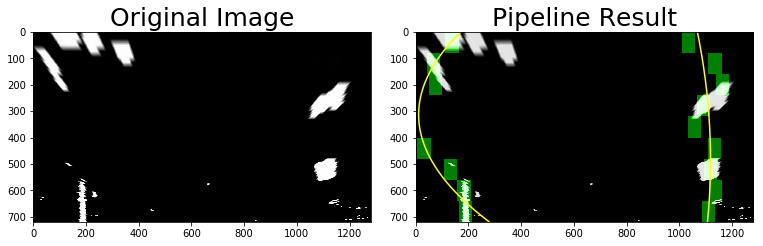

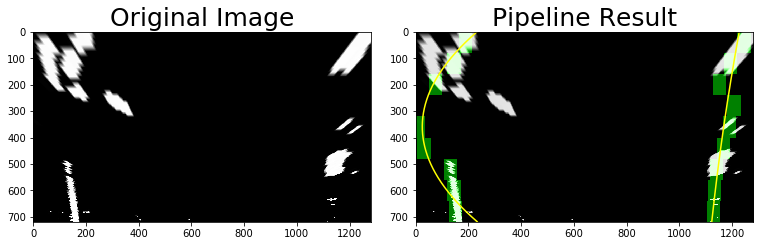

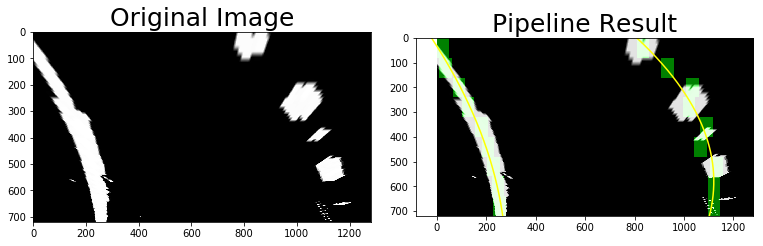

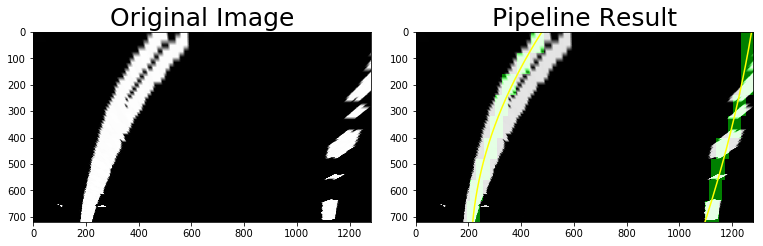

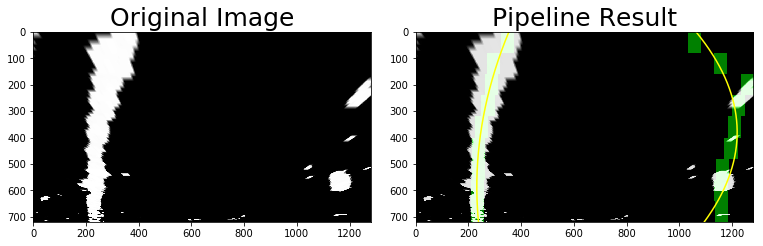

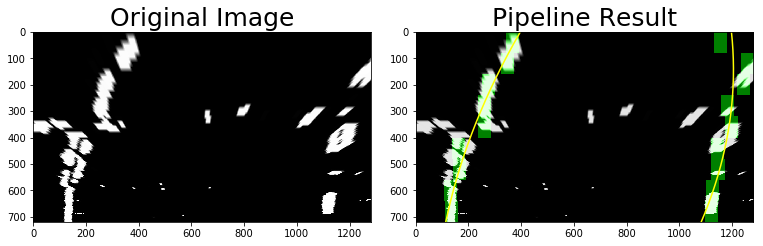

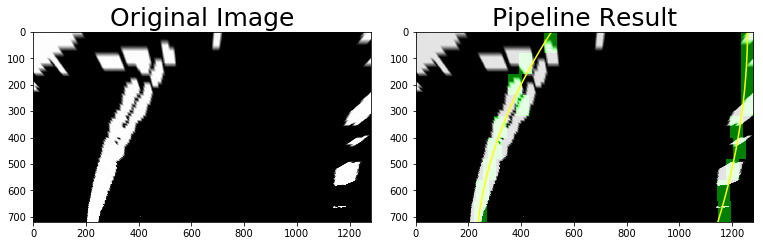

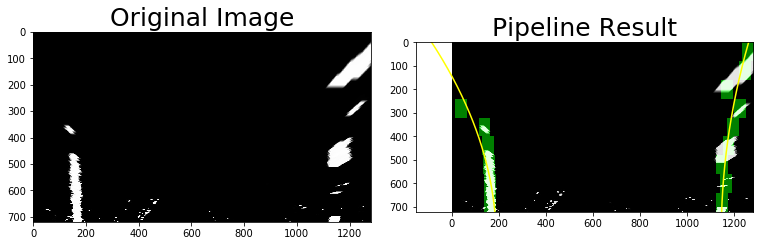

In [140]:
import matplotlib.image as mpimg

# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/output_images/warp*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)
    global_left_fitx = []
    global_right_fitx = []
    output,ploty,left_fitx,right_fitx = detect_lanes(image,50)

    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'detect' + str(i) + '.jpg'
    cv2.imwrite(file_path,output)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    image = np.array(cv2.merge((image,image,image)),np.uint8)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)

    ax2.imshow(output)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

## Determine the curvature of the lane and vehicle position with respect to center.

1577.39108801 1515.21960079
518.066075664 m 497.399006335 m


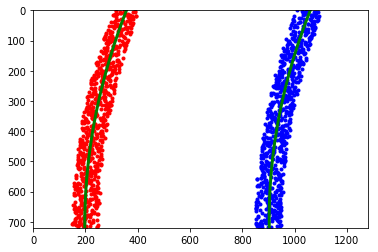

In [17]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

## Warp the detected lane boundaries back onto the original image.

In [18]:
def warp_back(warped,undist,M,ploty,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [19]:
clip2 = VideoFileClip("project_video.mp4").save_frame('test7.jpg', t=22.5, withmask=True)
clip2 = VideoFileClip("project_video.mp4").save_frame('test8.jpg', t=23.0, withmask=True)
clip2 = VideoFileClip("project_video.mp4").save_frame('test9.jpg', t=23.5, withmask=True)
clip2 = VideoFileClip("project_video.mp4").save_frame('test10.jpg', t=24.0, withmask=True)


NameError: name 'VideoFileClip' is not defined

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [141]:
def process_image(img):
    undist = undistort_image(img, mtx, dist)
    img_binary, img_stack = image_threshold(undist)
    warped,Minv = image_unwarp(img_binary)
    lanes,ploty,left_fitx,right_fitx = detect_lanes(warped,50)
    output = warp_back(warped,undist,Minv,ploty,left_fitx,right_fitx)
    
    output1 = cv2.resize(img_stack,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(lanes,(640, 360), interpolation = cv2.INTER_AREA)

    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))

    print(vis.shape)
    print(output.shape)   

    # Copy both images into the composite image.
    vis[:720, :1280,:] = output
    vis[:360, 1280:1920,:] = output1
    vis[360:720, 1280:1920,:] = output2
    
    return vis
    #warped = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    #return warped

In [142]:
dist_pickle = pickle.load( open( "calibration_results.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
global_left_fitx = []
global_right_fitx = []

project_output = 'project_output.mp4'

clip1 = VideoFileClip("project_video.mp4")#.subclip(21,24)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

  self.nchannels))



(720, 1920, 3)
(720, 1280, 3)
[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


  0%|          | 1/1261 [00:00<07:19,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


  0%|          | 2/1261 [00:00<07:22,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


  0%|          | 3/1261 [00:01<07:17,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


  0%|          | 4/1261 [00:01<07:13,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


  0%|          | 5/1261 [00:01<07:15,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


  0%|          | 6/1261 [00:02<07:11,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 7/1261 [00:02<07:06,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 8/1261 [00:02<07:03,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 9/1261 [00:03<07:01,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 10/1261 [00:03<07:03,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 11/1261 [00:03<07:04,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 12/1261 [00:04<07:09,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 13/1261 [00:04<07:24,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 14/1261 [00:04<07:24,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 15/1261 [00:05<07:17,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|▏         | 16/1261 [00:05<07:12,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|▏         | 17/1261 [00:05<07:08,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|▏         | 18/1261 [00:06<07:06,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 19/1261 [00:06<07:03,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 20/1261 [00:06<07:04,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 21/1261 [00:07<07:02,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 22/1261 [00:07<07:00,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 23/1261 [00:07<06:57,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 24/1261 [00:08<06:56,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 25/1261 [00:08<06:56,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 26/1261 [00:08<07:06,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 27/1261 [00:09<07:10,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 28/1261 [00:09<07:08,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 29/1261 [00:09<07:04,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 30/1261 [00:10<07:02,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 31/1261 [00:10<06:57,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 32/1261 [00:11<07:04,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 33/1261 [00:11<07:54,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 34/1261 [00:11<08:35,  2.38it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 35/1261 [00:12<08:14,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 36/1261 [00:12<07:53,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 37/1261 [00:13<07:38,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 38/1261 [00:13<07:26,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 39/1261 [00:13<07:40,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 40/1261 [00:14<07:38,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 41/1261 [00:14<07:48,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 42/1261 [00:14<07:30,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 43/1261 [00:15<07:23,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 44/1261 [00:15<07:15,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▎         | 45/1261 [00:16<07:45,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▎         | 46/1261 [00:16<07:28,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▎         | 47/1261 [00:16<07:22,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 48/1261 [00:17<07:09,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 49/1261 [00:17<07:06,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 50/1261 [00:17<06:57,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 51/1261 [00:18<06:50,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 52/1261 [00:18<06:47,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 53/1261 [00:18<06:44,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 54/1261 [00:19<06:44,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 55/1261 [00:19<06:45,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 56/1261 [00:19<06:54,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 57/1261 [00:20<06:57,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 58/1261 [00:20<06:54,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 59/1261 [00:20<06:49,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 60/1261 [00:21<07:03,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 61/1261 [00:21<07:29,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 62/1261 [00:22<07:49,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 63/1261 [00:22<08:03,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▌         | 64/1261 [00:23<09:50,  2.03it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▌         | 65/1261 [00:23<10:17,  1.94it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▌         | 66/1261 [00:24<10:54,  1.83it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▌         | 67/1261 [00:24<10:59,  1.81it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▌         | 68/1261 [00:25<10:57,  1.81it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▌         | 69/1261 [00:25<10:50,  1.83it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 70/1261 [00:26<10:38,  1.86it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 71/1261 [00:26<10:05,  1.96it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 72/1261 [00:27<09:43,  2.04it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 73/1261 [00:27<09:22,  2.11it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 74/1261 [00:28<09:11,  2.15it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 75/1261 [00:28<09:20,  2.12it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 76/1261 [00:29<09:03,  2.18it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 77/1261 [00:29<08:42,  2.27it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 78/1261 [00:29<08:07,  2.43it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▋         | 79/1261 [00:30<07:44,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▋         | 80/1261 [00:30<07:25,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▋         | 81/1261 [00:30<07:05,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 82/1261 [00:31<06:57,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 83/1261 [00:31<06:47,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 84/1261 [00:31<06:46,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 85/1261 [00:32<06:36,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 86/1261 [00:32<06:34,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 87/1261 [00:32<06:31,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 88/1261 [00:33<06:29,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 89/1261 [00:33<06:33,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 90/1261 [00:33<06:26,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 91/1261 [00:34<06:33,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 92/1261 [00:34<06:27,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 93/1261 [00:34<06:21,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 94/1261 [00:35<06:18,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 95/1261 [00:35<06:18,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 96/1261 [00:35<06:16,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 97/1261 [00:36<06:17,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 98/1261 [00:36<06:20,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 99/1261 [00:36<06:21,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 100/1261 [00:37<06:24,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 101/1261 [00:37<06:20,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 102/1261 [00:37<06:17,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 103/1261 [00:38<06:15,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 104/1261 [00:38<06:18,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 105/1261 [00:38<06:19,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 106/1261 [00:39<06:16,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 107/1261 [00:39<06:20,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▊         | 108/1261 [00:39<06:16,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▊         | 109/1261 [00:40<06:15,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▊         | 110/1261 [00:40<06:16,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 111/1261 [00:40<06:16,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 112/1261 [00:41<06:12,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 113/1261 [00:41<06:14,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 114/1261 [00:41<06:11,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 115/1261 [00:42<06:10,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 116/1261 [00:42<06:11,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 117/1261 [00:42<06:06,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 118/1261 [00:43<06:06,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 119/1261 [00:43<06:10,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|▉         | 120/1261 [00:43<06:07,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|▉         | 121/1261 [00:44<06:11,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|▉         | 122/1261 [00:44<06:15,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|▉         | 123/1261 [00:44<06:12,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|▉         | 124/1261 [00:45<06:12,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|▉         | 125/1261 [00:45<06:09,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|▉         | 126/1261 [00:45<06:08,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|█         | 127/1261 [00:45<06:11,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|█         | 128/1261 [00:46<06:11,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|█         | 129/1261 [00:46<06:17,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|█         | 130/1261 [00:47<06:17,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|█         | 131/1261 [00:47<06:19,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|█         | 132/1261 [00:47<06:21,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 133/1261 [00:48<06:21,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 134/1261 [00:48<06:19,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 135/1261 [00:48<06:13,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 136/1261 [00:48<06:09,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 137/1261 [00:49<06:09,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 138/1261 [00:49<06:20,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 139/1261 [00:50<06:14,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 140/1261 [00:50<06:11,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 141/1261 [00:50<06:11,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█▏        | 142/1261 [00:50<06:08,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█▏        | 143/1261 [00:51<06:12,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█▏        | 144/1261 [00:51<06:08,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█▏        | 145/1261 [00:51<06:06,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 146/1261 [00:52<06:11,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 147/1261 [00:52<06:12,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 148/1261 [00:52<06:11,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 149/1261 [00:53<06:07,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 150/1261 [00:53<06:07,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 151/1261 [00:53<06:07,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 152/1261 [00:54<06:06,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 153/1261 [00:54<06:06,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 154/1261 [00:54<06:04,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 155/1261 [00:55<06:05,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 156/1261 [00:55<06:07,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 157/1261 [00:55<06:08,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 158/1261 [00:56<06:05,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 159/1261 [00:56<06:01,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 160/1261 [00:56<05:58,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 161/1261 [00:57<06:01,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 162/1261 [00:57<05:56,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 163/1261 [00:57<06:01,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 164/1261 [00:58<05:59,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 165/1261 [00:58<05:58,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 166/1261 [00:58<06:03,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 167/1261 [00:59<06:00,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 168/1261 [00:59<06:04,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 169/1261 [00:59<06:04,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 170/1261 [01:00<05:59,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▎        | 171/1261 [01:00<05:58,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▎        | 172/1261 [01:00<05:54,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▎        | 173/1261 [01:01<05:53,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 174/1261 [01:01<05:53,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 175/1261 [01:01<05:54,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 176/1261 [01:02<05:56,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 177/1261 [01:02<05:56,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 178/1261 [01:02<05:54,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 179/1261 [01:03<05:52,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 180/1261 [01:03<05:52,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 181/1261 [01:03<05:52,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 182/1261 [01:04<05:52,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▍        | 183/1261 [01:04<05:57,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▍        | 184/1261 [01:04<05:56,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▍        | 185/1261 [01:05<05:55,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▍        | 186/1261 [01:05<05:55,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▍        | 187/1261 [01:05<05:53,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▍        | 188/1261 [01:06<05:55,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▍        | 189/1261 [01:06<05:55,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▌        | 190/1261 [01:06<05:52,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▌        | 191/1261 [01:07<05:49,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▌        | 192/1261 [01:07<05:50,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▌        | 193/1261 [01:07<05:46,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▌        | 194/1261 [01:08<05:45,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▌        | 195/1261 [01:08<05:43,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 196/1261 [01:08<05:44,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 197/1261 [01:09<05:44,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 198/1261 [01:09<05:47,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 199/1261 [01:09<05:45,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 200/1261 [01:10<05:44,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 201/1261 [01:10<05:51,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 202/1261 [01:10<05:59,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 203/1261 [01:11<05:56,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 204/1261 [01:11<05:59,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▋        | 205/1261 [01:11<05:59,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▋        | 206/1261 [01:12<05:57,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▋        | 207/1261 [01:12<05:58,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▋        | 208/1261 [01:12<05:56,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 209/1261 [01:13<05:52,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 210/1261 [01:13<05:53,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 211/1261 [01:13<05:48,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 212/1261 [01:14<05:45,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 213/1261 [01:14<05:49,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 214/1261 [01:14<05:49,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 215/1261 [01:15<05:50,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 216/1261 [01:15<05:50,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 217/1261 [01:15<05:52,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 218/1261 [01:16<05:47,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 219/1261 [01:16<05:46,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 220/1261 [01:16<05:42,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 221/1261 [01:17<05:42,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 222/1261 [01:17<05:40,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 223/1261 [01:17<05:36,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 224/1261 [01:18<05:34,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 225/1261 [01:18<05:34,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 226/1261 [01:18<05:34,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 227/1261 [01:19<05:34,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 228/1261 [01:19<05:36,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 229/1261 [01:19<05:38,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 230/1261 [01:20<05:43,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 231/1261 [01:20<05:42,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 232/1261 [01:20<05:41,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 233/1261 [01:21<05:37,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▊        | 234/1261 [01:21<05:34,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▊        | 235/1261 [01:21<05:32,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▊        | 236/1261 [01:21<05:31,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 237/1261 [01:22<05:33,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 238/1261 [01:22<05:32,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 239/1261 [01:22<05:30,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 240/1261 [01:23<05:28,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 241/1261 [01:23<05:26,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 242/1261 [01:23<05:28,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 243/1261 [01:24<05:29,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 244/1261 [01:24<05:33,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 245/1261 [01:24<05:37,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|█▉        | 246/1261 [01:25<05:47,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|█▉        | 247/1261 [01:25<05:49,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|█▉        | 248/1261 [01:25<05:46,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|█▉        | 249/1261 [01:26<05:49,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|█▉        | 250/1261 [01:26<05:44,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|█▉        | 251/1261 [01:26<05:37,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|█▉        | 252/1261 [01:27<05:40,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|██        | 253/1261 [01:27<05:41,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|██        | 254/1261 [01:27<05:37,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|██        | 255/1261 [01:28<05:34,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|██        | 256/1261 [01:28<05:30,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|██        | 257/1261 [01:28<05:30,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|██        | 258/1261 [01:29<05:32,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 259/1261 [01:29<05:29,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 260/1261 [01:29<05:27,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 261/1261 [01:30<05:29,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 262/1261 [01:30<05:28,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 263/1261 [01:30<05:26,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 264/1261 [01:31<05:26,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 265/1261 [01:31<05:32,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 266/1261 [01:31<05:34,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 267/1261 [01:32<05:33,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██▏       | 268/1261 [01:32<05:34,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██▏       | 269/1261 [01:32<05:27,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██▏       | 270/1261 [01:33<05:24,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██▏       | 271/1261 [01:33<05:25,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 272/1261 [01:33<05:23,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 273/1261 [01:34<05:23,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 274/1261 [01:34<05:28,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 275/1261 [01:34<05:25,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 276/1261 [01:35<05:27,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 277/1261 [01:35<05:27,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 278/1261 [01:35<05:22,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 279/1261 [01:36<05:22,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 280/1261 [01:36<05:26,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 281/1261 [01:36<05:28,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 282/1261 [01:37<05:27,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 283/1261 [01:37<05:28,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 284/1261 [01:37<05:25,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 285/1261 [01:38<05:26,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 286/1261 [01:38<05:25,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 287/1261 [01:38<05:22,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 288/1261 [01:39<05:26,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 289/1261 [01:39<05:24,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 290/1261 [01:39<05:22,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 291/1261 [01:40<05:24,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 292/1261 [01:40<05:20,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 293/1261 [01:40<05:15,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 294/1261 [01:41<05:12,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 295/1261 [01:41<05:11,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 296/1261 [01:41<05:11,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▎       | 297/1261 [01:42<05:10,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▎       | 298/1261 [01:42<05:12,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▎       | 299/1261 [01:42<05:14,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 300/1261 [01:43<05:13,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 301/1261 [01:43<05:13,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 302/1261 [01:43<05:09,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 303/1261 [01:44<05:08,  3.11it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 304/1261 [01:44<05:08,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 305/1261 [01:44<05:08,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 306/1261 [01:45<05:06,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 307/1261 [01:45<05:09,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 308/1261 [01:45<05:48,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 309/1261 [01:46<06:08,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 310/1261 [01:46<05:49,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 311/1261 [01:46<05:39,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 312/1261 [01:47<05:31,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 313/1261 [01:47<05:54,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 314/1261 [01:48<06:01,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 315/1261 [01:48<05:46,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▌       | 316/1261 [01:48<05:37,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▌       | 317/1261 [01:49<05:34,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▌       | 318/1261 [01:49<05:54,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▌       | 319/1261 [01:50<07:13,  2.17it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▌       | 320/1261 [01:50<07:05,  2.21it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▌       | 321/1261 [01:51<06:49,  2.30it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 322/1261 [01:51<06:41,  2.34it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 323/1261 [01:51<06:24,  2.44it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 324/1261 [01:52<06:34,  2.38it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 325/1261 [01:52<06:44,  2.31it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 326/1261 [01:53<06:41,  2.33it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 327/1261 [01:53<06:31,  2.39it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 328/1261 [01:53<06:11,  2.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 329/1261 [01:54<06:05,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 330/1261 [01:54<05:58,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 331/1261 [01:55<05:49,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▋       | 332/1261 [01:55<06:00,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▋       | 333/1261 [01:55<05:46,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▋       | 334/1261 [01:56<05:38,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 335/1261 [01:56<05:30,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 336/1261 [01:56<05:21,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 337/1261 [01:57<05:21,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 338/1261 [01:57<05:18,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 339/1261 [01:57<05:13,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 340/1261 [01:58<05:09,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 341/1261 [01:58<05:09,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 342/1261 [01:58<05:04,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 343/1261 [01:59<05:03,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 344/1261 [01:59<05:04,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 345/1261 [01:59<05:02,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 346/1261 [02:00<04:59,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 347/1261 [02:00<05:02,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 348/1261 [02:00<05:09,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 349/1261 [02:01<05:03,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 350/1261 [02:01<05:05,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 351/1261 [02:01<05:07,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 352/1261 [02:02<05:28,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 353/1261 [02:02<05:41,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 354/1261 [02:02<05:32,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 355/1261 [02:03<05:38,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 356/1261 [02:03<05:36,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 357/1261 [02:04<05:34,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 358/1261 [02:04<05:28,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 359/1261 [02:04<05:29,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▊       | 360/1261 [02:05<05:30,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▊       | 361/1261 [02:05<05:24,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▊       | 362/1261 [02:05<05:13,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 363/1261 [02:06<05:05,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 364/1261 [02:06<05:05,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 365/1261 [02:06<05:03,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 366/1261 [02:07<05:01,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 367/1261 [02:07<05:00,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 368/1261 [02:07<04:55,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 369/1261 [02:08<04:55,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 370/1261 [02:08<05:00,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 371/1261 [02:08<04:59,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|██▉       | 372/1261 [02:09<05:01,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|██▉       | 373/1261 [02:09<05:01,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|██▉       | 374/1261 [02:09<05:00,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|██▉       | 375/1261 [02:10<04:57,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|██▉       | 376/1261 [02:10<04:57,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|██▉       | 377/1261 [02:10<04:54,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|██▉       | 378/1261 [02:11<04:53,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|███       | 379/1261 [02:11<04:52,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|███       | 380/1261 [02:11<04:53,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|███       | 381/1261 [02:12<04:54,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|███       | 382/1261 [02:12<04:54,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|███       | 383/1261 [02:12<04:51,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|███       | 384/1261 [02:13<04:53,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 385/1261 [02:13<04:48,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 386/1261 [02:13<04:52,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 387/1261 [02:14<04:50,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 388/1261 [02:14<04:51,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 389/1261 [02:14<04:52,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 390/1261 [02:15<04:50,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 391/1261 [02:15<04:48,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 392/1261 [02:15<04:48,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 393/1261 [02:16<04:45,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 394/1261 [02:16<04:44,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███▏      | 395/1261 [02:16<04:43,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███▏      | 396/1261 [02:17<04:42,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███▏      | 397/1261 [02:17<04:44,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 398/1261 [02:17<04:45,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 399/1261 [02:18<04:43,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 400/1261 [02:18<04:46,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 401/1261 [02:18<04:48,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 402/1261 [02:19<04:50,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 403/1261 [02:19<04:59,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 404/1261 [02:19<05:00,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 405/1261 [02:20<04:52,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 406/1261 [02:20<04:55,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 407/1261 [02:20<04:47,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 408/1261 [02:21<04:45,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 409/1261 [02:21<04:43,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 410/1261 [02:21<04:43,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 411/1261 [02:22<04:43,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 412/1261 [02:22<04:48,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 413/1261 [02:22<05:05,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 414/1261 [02:23<05:12,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 415/1261 [02:23<05:13,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 416/1261 [02:24<05:11,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 417/1261 [02:24<05:11,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 418/1261 [02:24<05:14,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 419/1261 [02:25<05:06,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 420/1261 [02:25<05:01,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 421/1261 [02:25<04:57,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 422/1261 [02:26<04:49,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▎      | 423/1261 [02:26<04:48,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▎      | 424/1261 [02:26<04:49,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▎      | 425/1261 [02:27<04:55,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 426/1261 [02:27<04:49,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 427/1261 [02:27<04:46,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 428/1261 [02:28<04:43,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 429/1261 [02:28<04:47,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 430/1261 [02:28<04:45,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 431/1261 [02:29<04:40,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 432/1261 [02:29<04:43,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 433/1261 [02:29<04:43,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 434/1261 [02:30<04:47,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 435/1261 [02:30<04:45,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▍      | 436/1261 [02:31<04:46,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▍      | 437/1261 [02:31<04:38,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▍      | 438/1261 [02:31<04:38,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▍      | 439/1261 [02:32<04:35,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▍      | 440/1261 [02:32<04:32,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▍      | 441/1261 [02:32<04:28,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▌      | 442/1261 [02:33<04:28,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▌      | 443/1261 [02:33<04:25,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▌      | 444/1261 [02:33<04:26,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▌      | 445/1261 [02:33<04:27,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▌      | 446/1261 [02:34<04:26,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▌      | 447/1261 [02:34<04:26,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 448/1261 [02:34<04:25,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 449/1261 [02:35<04:27,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 450/1261 [02:35<04:31,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 451/1261 [02:35<04:31,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 452/1261 [02:36<04:31,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 453/1261 [02:36<04:28,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 454/1261 [02:36<04:27,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 455/1261 [02:37<04:24,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 456/1261 [02:37<04:25,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 457/1261 [02:37<04:28,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▋      | 458/1261 [02:38<04:30,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▋      | 459/1261 [02:38<04:29,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▋      | 460/1261 [02:38<04:26,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 461/1261 [02:39<04:30,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 462/1261 [02:39<04:38,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 463/1261 [02:40<04:39,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 464/1261 [02:40<04:34,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 465/1261 [02:40<04:30,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 466/1261 [02:41<04:26,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 467/1261 [02:41<04:23,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 468/1261 [02:41<04:24,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 469/1261 [02:42<04:27,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 470/1261 [02:42<04:25,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 471/1261 [02:42<04:23,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 472/1261 [02:43<04:25,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 473/1261 [02:43<04:25,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 474/1261 [02:43<04:22,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 475/1261 [02:44<04:22,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 476/1261 [02:44<04:23,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 477/1261 [02:44<04:22,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 478/1261 [02:45<04:21,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 479/1261 [02:45<04:20,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 480/1261 [02:45<04:18,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 481/1261 [02:46<04:17,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 482/1261 [02:46<04:23,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 483/1261 [02:46<04:24,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 484/1261 [02:47<04:23,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 485/1261 [02:47<04:23,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▊      | 486/1261 [02:47<04:18,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▊      | 487/1261 [02:48<04:25,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▊      | 488/1261 [02:48<04:22,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 489/1261 [02:48<04:28,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 490/1261 [02:49<04:52,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 491/1261 [02:49<04:50,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 492/1261 [02:49<04:37,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 493/1261 [02:50<04:31,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 494/1261 [02:50<04:33,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 495/1261 [02:50<04:30,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 496/1261 [02:51<04:23,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 497/1261 [02:51<04:20,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 498/1261 [02:52<04:28,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|███▉      | 499/1261 [02:52<04:36,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|███▉      | 500/1261 [02:52<04:33,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|███▉      | 501/1261 [02:53<04:37,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|███▉      | 502/1261 [02:53<04:36,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|███▉      | 503/1261 [02:53<04:49,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|███▉      | 504/1261 [02:54<04:40,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|████      | 505/1261 [02:54<04:32,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|████      | 506/1261 [02:54<04:32,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|████      | 507/1261 [02:55<04:36,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|████      | 508/1261 [02:55<04:39,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|████      | 509/1261 [02:56<04:32,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|████      | 510/1261 [02:56<04:49,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 511/1261 [02:56<04:47,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 512/1261 [02:57<04:37,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 513/1261 [02:57<04:29,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 514/1261 [02:57<04:24,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 515/1261 [02:58<04:20,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 516/1261 [02:58<04:18,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 517/1261 [02:58<04:12,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 518/1261 [02:59<04:23,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 519/1261 [02:59<04:19,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 520/1261 [03:00<04:29,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████▏     | 521/1261 [03:00<04:29,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████▏     | 522/1261 [03:00<04:27,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████▏     | 523/1261 [03:01<04:25,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 524/1261 [03:01<04:22,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 525/1261 [03:01<04:23,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 526/1261 [03:02<04:19,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 527/1261 [03:02<04:18,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 528/1261 [03:02<04:14,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 529/1261 [03:03<04:14,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 530/1261 [03:03<04:11,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 531/1261 [03:03<04:08,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 532/1261 [03:04<04:05,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 533/1261 [03:04<04:03,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 534/1261 [03:04<04:15,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 535/1261 [03:05<04:34,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 536/1261 [03:05<04:28,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 537/1261 [03:06<04:17,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 538/1261 [03:06<04:10,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 539/1261 [03:06<04:09,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 540/1261 [03:07<04:07,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 541/1261 [03:07<04:06,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 542/1261 [03:07<04:14,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 543/1261 [03:08<04:10,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 544/1261 [03:08<04:13,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 545/1261 [03:08<04:06,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 546/1261 [03:09<04:03,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 547/1261 [03:09<04:04,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 548/1261 [03:09<03:58,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▎     | 549/1261 [03:10<03:57,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▎     | 550/1261 [03:10<03:59,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▎     | 551/1261 [03:10<03:57,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 552/1261 [03:11<03:54,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 553/1261 [03:11<03:54,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 554/1261 [03:11<03:51,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 555/1261 [03:12<03:50,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 556/1261 [03:12<03:50,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 557/1261 [03:12<03:50,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 558/1261 [03:13<03:47,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 559/1261 [03:13<03:46,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 560/1261 [03:13<03:46,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 561/1261 [03:14<03:46,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▍     | 562/1261 [03:14<03:44,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▍     | 563/1261 [03:14<03:46,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▍     | 564/1261 [03:14<03:45,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▍     | 565/1261 [03:15<03:43,  3.11it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▍     | 566/1261 [03:15<03:45,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▍     | 567/1261 [03:15<03:45,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▌     | 568/1261 [03:16<03:45,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▌     | 569/1261 [03:16<03:50,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▌     | 570/1261 [03:16<03:52,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▌     | 571/1261 [03:17<03:55,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▌     | 572/1261 [03:17<03:52,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▌     | 573/1261 [03:17<03:49,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 574/1261 [03:18<03:57,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 575/1261 [03:18<03:57,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 576/1261 [03:19<03:55,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 577/1261 [03:19<03:52,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 578/1261 [03:19<03:51,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 579/1261 [03:20<04:19,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 580/1261 [03:20<04:37,  2.45it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 581/1261 [03:21<04:28,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 582/1261 [03:21<04:16,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 583/1261 [03:21<05:05,  2.22it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▋     | 584/1261 [03:22<05:28,  2.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▋     | 585/1261 [03:23<05:29,  2.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▋     | 586/1261 [03:23<05:33,  2.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 587/1261 [03:24<05:41,  1.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 588/1261 [03:24<05:17,  2.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 589/1261 [03:24<04:54,  2.28it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 590/1261 [03:25<04:35,  2.44it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 591/1261 [03:25<04:18,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 592/1261 [03:25<04:20,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 593/1261 [03:26<04:18,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 594/1261 [03:26<04:14,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 595/1261 [03:27<04:07,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 596/1261 [03:27<04:31,  2.45it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 597/1261 [03:28<05:45,  1.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 598/1261 [03:28<05:59,  1.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 599/1261 [03:29<05:52,  1.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 600/1261 [03:29<05:38,  1.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 601/1261 [03:30<05:36,  1.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 602/1261 [03:30<05:33,  1.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 603/1261 [03:31<05:23,  2.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 604/1261 [03:31<05:07,  2.14it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 605/1261 [03:32<04:47,  2.28it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 606/1261 [03:32<04:29,  2.43it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 607/1261 [03:32<04:27,  2.44it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 608/1261 [03:33<04:20,  2.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 609/1261 [03:33<04:19,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 610/1261 [03:33<04:12,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 611/1261 [03:34<04:08,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▊     | 612/1261 [03:34<04:05,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▊     | 613/1261 [03:35<03:59,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▊     | 614/1261 [03:35<03:53,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 615/1261 [03:35<03:49,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 616/1261 [03:36<03:45,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 617/1261 [03:36<03:44,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 618/1261 [03:36<03:40,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 619/1261 [03:37<03:38,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 620/1261 [03:37<03:43,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 621/1261 [03:37<03:46,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 622/1261 [03:38<03:48,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 623/1261 [03:38<03:55,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 624/1261 [03:39<04:01,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|████▉     | 625/1261 [03:39<04:12,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|████▉     | 626/1261 [03:39<04:07,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|████▉     | 627/1261 [03:40<04:00,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|████▉     | 628/1261 [03:40<03:53,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|████▉     | 629/1261 [03:40<03:53,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|████▉     | 630/1261 [03:41<03:59,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|█████     | 631/1261 [03:41<04:12,  2.49it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|█████     | 632/1261 [03:42<04:29,  2.33it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|█████     | 633/1261 [03:42<04:40,  2.24it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|█████     | 634/1261 [03:43<04:57,  2.11it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|█████     | 635/1261 [03:43<04:57,  2.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|█████     | 636/1261 [03:44<04:46,  2.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 637/1261 [03:44<04:52,  2.13it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 638/1261 [03:45<04:57,  2.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 639/1261 [03:45<04:51,  2.14it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 640/1261 [03:46<04:51,  2.13it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 641/1261 [03:46<04:46,  2.16it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 642/1261 [03:47<05:15,  1.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 643/1261 [03:47<05:26,  1.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 644/1261 [03:48<05:14,  1.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 645/1261 [03:48<05:07,  2.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 646/1261 [03:49<05:17,  1.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████▏    | 647/1261 [03:49<05:29,  1.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████▏    | 648/1261 [03:50<05:14,  1.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████▏    | 649/1261 [03:50<05:27,  1.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 650/1261 [03:51<06:03,  1.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 651/1261 [03:52<05:45,  1.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 652/1261 [03:52<05:38,  1.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 653/1261 [03:53<05:43,  1.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 654/1261 [03:53<05:54,  1.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 655/1261 [03:54<05:49,  1.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 656/1261 [03:54<05:48,  1.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 657/1261 [03:55<05:54,  1.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 658/1261 [03:56<05:41,  1.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 659/1261 [03:56<05:26,  1.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 660/1261 [03:57<05:10,  1.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 661/1261 [03:57<05:28,  1.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 662/1261 [03:58<05:23,  1.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 663/1261 [03:59<06:18,  1.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 664/1261 [03:59<06:01,  1.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 665/1261 [04:00<06:14,  1.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 666/1261 [04:00<05:58,  1.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 667/1261 [04:01<05:43,  1.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 668/1261 [04:01<05:43,  1.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 669/1261 [04:02<06:04,  1.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 670/1261 [04:03<06:25,  1.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 671/1261 [04:03<06:13,  1.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 672/1261 [04:04<06:30,  1.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 673/1261 [04:05<06:23,  1.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 674/1261 [04:05<05:58,  1.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▎    | 675/1261 [04:06<06:04,  1.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▎    | 676/1261 [04:06<05:51,  1.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▎    | 677/1261 [04:07<06:07,  1.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 678/1261 [04:08<05:43,  1.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 679/1261 [04:08<05:44,  1.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 680/1261 [04:09<05:59,  1.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 681/1261 [04:10<06:01,  1.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 682/1261 [04:10<06:04,  1.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 683/1261 [04:11<06:11,  1.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 684/1261 [04:12<06:02,  1.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 685/1261 [04:12<06:26,  1.49it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 686/1261 [04:13<05:54,  1.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 687/1261 [04:13<05:50,  1.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▍    | 688/1261 [04:14<06:01,  1.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▍    | 689/1261 [04:15<05:59,  1.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▍    | 690/1261 [04:15<05:19,  1.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▍    | 691/1261 [04:15<04:43,  2.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▍    | 692/1261 [04:16<04:20,  2.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▍    | 693/1261 [04:16<04:23,  2.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▌    | 694/1261 [04:17<04:04,  2.32it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▌    | 695/1261 [04:17<03:49,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▌    | 696/1261 [04:17<03:39,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▌    | 697/1261 [04:18<03:50,  2.45it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▌    | 698/1261 [04:18<04:00,  2.34it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▌    | 699/1261 [04:19<03:57,  2.37it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 700/1261 [04:19<03:52,  2.41it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 701/1261 [04:19<03:56,  2.37it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 702/1261 [04:20<03:48,  2.45it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 703/1261 [04:20<03:48,  2.44it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 704/1261 [04:21<03:49,  2.42it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 705/1261 [04:21<03:39,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 706/1261 [04:22<04:03,  2.28it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 707/1261 [04:22<03:57,  2.33it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 708/1261 [04:22<04:02,  2.28it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 709/1261 [04:23<03:57,  2.32it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▋    | 710/1261 [04:23<03:50,  2.39it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▋    | 711/1261 [04:24<03:42,  2.47it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▋    | 712/1261 [04:24<03:38,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 713/1261 [04:24<03:33,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 714/1261 [04:25<03:47,  2.40it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 715/1261 [04:25<03:43,  2.45it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 716/1261 [04:26<03:32,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 717/1261 [04:26<03:24,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 718/1261 [04:26<03:20,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 719/1261 [04:27<03:15,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 720/1261 [04:27<03:13,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 721/1261 [04:27<03:10,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 722/1261 [04:28<03:04,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 723/1261 [04:28<03:01,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 724/1261 [04:28<02:59,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 725/1261 [04:29<03:00,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 726/1261 [04:29<03:00,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 727/1261 [04:29<03:04,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 728/1261 [04:30<03:03,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 729/1261 [04:30<03:03,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 730/1261 [04:30<03:02,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 731/1261 [04:31<02:59,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 732/1261 [04:31<02:56,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 733/1261 [04:31<02:54,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 734/1261 [04:32<02:54,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 735/1261 [04:32<02:53,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 736/1261 [04:32<02:51,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 737/1261 [04:33<02:49,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▊    | 738/1261 [04:33<02:49,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▊    | 739/1261 [04:33<02:52,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▊    | 740/1261 [04:34<02:59,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 741/1261 [04:34<03:02,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 742/1261 [04:34<03:03,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 743/1261 [04:35<03:02,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 744/1261 [04:35<03:00,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 745/1261 [04:35<02:57,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 746/1261 [04:36<03:00,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 747/1261 [04:36<02:56,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 748/1261 [04:36<02:57,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 749/1261 [04:37<02:54,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 750/1261 [04:37<03:18,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|█████▉    | 751/1261 [04:38<03:27,  2.45it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|█████▉    | 752/1261 [04:38<03:30,  2.42it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|█████▉    | 753/1261 [04:39<03:18,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|█████▉    | 754/1261 [04:39<03:10,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|█████▉    | 755/1261 [04:39<03:04,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|█████▉    | 756/1261 [04:40<03:03,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|██████    | 757/1261 [04:40<03:05,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|██████    | 758/1261 [04:40<03:17,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|██████    | 759/1261 [04:41<03:24,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|██████    | 760/1261 [04:41<03:28,  2.40it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|██████    | 761/1261 [04:42<03:33,  2.34it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|██████    | 762/1261 [04:42<03:29,  2.39it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 763/1261 [04:42<03:17,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 764/1261 [04:43<03:11,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 765/1261 [04:43<03:09,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 766/1261 [04:44<03:09,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 767/1261 [04:44<03:13,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 768/1261 [04:44<03:11,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 769/1261 [04:45<03:11,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 770/1261 [04:45<03:05,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 771/1261 [04:45<02:58,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 772/1261 [04:46<02:56,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████▏   | 773/1261 [04:46<03:03,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████▏   | 774/1261 [04:47<03:19,  2.45it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████▏   | 775/1261 [04:47<03:09,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 776/1261 [04:47<03:02,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 777/1261 [04:48<03:01,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 778/1261 [04:48<03:07,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 779/1261 [04:49<03:06,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 780/1261 [04:49<03:01,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 781/1261 [04:49<02:57,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 782/1261 [04:50<02:55,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 783/1261 [04:50<02:51,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 784/1261 [04:50<02:51,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 785/1261 [04:51<02:50,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 786/1261 [04:51<02:47,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 787/1261 [04:51<02:46,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 788/1261 [04:52<02:43,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 789/1261 [04:52<02:40,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 790/1261 [04:52<02:43,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 791/1261 [04:53<02:50,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 792/1261 [04:53<03:05,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 793/1261 [04:54<03:09,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 794/1261 [04:54<03:02,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 795/1261 [04:54<02:55,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 796/1261 [04:55<02:58,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 797/1261 [04:55<03:06,  2.49it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 798/1261 [04:56<03:17,  2.34it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 799/1261 [04:56<03:12,  2.40it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 800/1261 [04:56<03:05,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▎   | 801/1261 [04:57<02:57,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▎   | 802/1261 [04:57<02:51,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▎   | 803/1261 [04:58<02:56,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 804/1261 [04:58<02:54,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 805/1261 [04:58<02:53,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 806/1261 [04:59<02:48,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 807/1261 [04:59<02:44,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 808/1261 [04:59<02:41,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 809/1261 [05:00<02:40,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 810/1261 [05:00<02:38,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 811/1261 [05:00<02:42,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 812/1261 [05:01<02:49,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 813/1261 [05:01<03:02,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▍   | 814/1261 [05:02<02:56,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▍   | 815/1261 [05:02<03:16,  2.27it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▍   | 816/1261 [05:03<03:42,  2.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▍   | 817/1261 [05:03<03:39,  2.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▍   | 818/1261 [05:04<03:32,  2.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▍   | 819/1261 [05:04<03:24,  2.16it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▌   | 820/1261 [05:05<03:37,  2.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▌   | 821/1261 [05:05<03:35,  2.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▌   | 822/1261 [05:06<03:28,  2.11it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▌   | 823/1261 [05:06<03:19,  2.19it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▌   | 824/1261 [05:07<03:15,  2.23it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▌   | 825/1261 [05:07<03:01,  2.40it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 826/1261 [05:07<02:49,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 827/1261 [05:08<02:40,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 828/1261 [05:08<02:34,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 829/1261 [05:08<02:31,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 830/1261 [05:09<02:26,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 831/1261 [05:09<02:24,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 832/1261 [05:09<02:22,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 833/1261 [05:10<02:21,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 834/1261 [05:10<02:20,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 835/1261 [05:10<02:19,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▋   | 836/1261 [05:11<02:18,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▋   | 837/1261 [05:11<02:22,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▋   | 838/1261 [05:11<02:22,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 839/1261 [05:12<02:22,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 840/1261 [05:12<02:21,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 841/1261 [05:12<02:20,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 842/1261 [05:13<02:18,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 843/1261 [05:13<02:18,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 844/1261 [05:13<02:16,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 845/1261 [05:14<02:15,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 846/1261 [05:14<02:14,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 847/1261 [05:14<02:19,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 848/1261 [05:15<02:20,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 849/1261 [05:15<02:22,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 850/1261 [05:15<02:25,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 851/1261 [05:16<02:32,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 852/1261 [05:16<02:41,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 853/1261 [05:16<02:34,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 854/1261 [05:17<02:28,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 855/1261 [05:17<02:23,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 856/1261 [05:17<02:18,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 857/1261 [05:18<02:19,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 858/1261 [05:18<02:19,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 859/1261 [05:19<02:20,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 860/1261 [05:19<02:20,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 861/1261 [05:19<02:18,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 862/1261 [05:20<02:16,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 863/1261 [05:20<02:15,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▊   | 864/1261 [05:20<02:21,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▊   | 865/1261 [05:21<02:27,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▊   | 866/1261 [05:21<02:39,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 867/1261 [05:21<02:33,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 868/1261 [05:22<02:30,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 869/1261 [05:22<02:38,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 870/1261 [05:23<02:51,  2.28it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 871/1261 [05:23<02:41,  2.42it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 872/1261 [05:24<02:30,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 873/1261 [05:24<02:26,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 874/1261 [05:24<02:26,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 875/1261 [05:25<02:32,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 876/1261 [05:25<02:35,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|██████▉   | 877/1261 [05:25<02:29,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|██████▉   | 878/1261 [05:26<02:24,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|██████▉   | 879/1261 [05:26<02:19,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|██████▉   | 880/1261 [05:26<02:16,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|██████▉   | 881/1261 [05:27<02:12,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|██████▉   | 882/1261 [05:27<02:10,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|███████   | 883/1261 [05:27<02:07,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|███████   | 884/1261 [05:28<02:05,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|███████   | 885/1261 [05:28<02:04,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|███████   | 886/1261 [05:28<02:04,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|███████   | 887/1261 [05:29<02:02,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|███████   | 888/1261 [05:29<02:04,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|███████   | 889/1261 [05:30<02:11,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 890/1261 [05:30<02:17,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 891/1261 [05:30<02:26,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 892/1261 [05:31<02:20,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 893/1261 [05:31<02:14,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 894/1261 [05:31<02:09,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 895/1261 [05:32<02:05,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 896/1261 [05:32<02:04,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 897/1261 [05:32<02:02,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 898/1261 [05:33<02:02,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████▏  | 899/1261 [05:33<02:03,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████▏  | 900/1261 [05:33<02:07,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████▏  | 901/1261 [05:34<02:12,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 902/1261 [05:34<02:18,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 903/1261 [05:35<02:16,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 904/1261 [05:35<02:17,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 905/1261 [05:35<02:19,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 906/1261 [05:36<02:14,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 907/1261 [05:36<02:10,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 908/1261 [05:37<02:15,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 909/1261 [05:37<02:18,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 910/1261 [05:37<02:15,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 911/1261 [05:38<02:11,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 912/1261 [05:38<02:05,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 913/1261 [05:38<02:07,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 914/1261 [05:39<02:03,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 915/1261 [05:39<02:02,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 916/1261 [05:39<02:00,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 917/1261 [05:40<01:59,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 918/1261 [05:40<01:58,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 919/1261 [05:40<01:58,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 920/1261 [05:41<02:12,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 921/1261 [05:41<02:22,  2.38it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 922/1261 [05:42<02:12,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 923/1261 [05:42<02:08,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 924/1261 [05:42<02:05,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 925/1261 [05:43<02:03,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 926/1261 [05:43<02:02,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▎  | 927/1261 [05:44<02:01,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▎  | 928/1261 [05:44<01:59,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▎  | 929/1261 [05:44<01:59,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 930/1261 [05:45<02:00,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 931/1261 [05:45<02:05,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 932/1261 [05:45<02:09,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 933/1261 [05:46<02:12,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 934/1261 [05:46<02:12,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 935/1261 [05:47<02:07,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 936/1261 [05:47<02:07,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 937/1261 [05:47<02:11,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 938/1261 [05:48<02:09,  2.49it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 939/1261 [05:48<02:06,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▍  | 940/1261 [05:49<02:04,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▍  | 941/1261 [05:49<02:02,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▍  | 942/1261 [05:49<01:59,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▍  | 943/1261 [05:50<01:59,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▍  | 944/1261 [05:50<01:59,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▍  | 945/1261 [05:50<01:59,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 946/1261 [05:51<02:00,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 947/1261 [05:51<02:04,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 948/1261 [05:52<02:03,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 949/1261 [05:52<02:03,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 950/1261 [05:53<02:05,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 951/1261 [05:53<02:04,  2.49it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 952/1261 [05:53<02:03,  2.50it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 953/1261 [05:54<01:59,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 954/1261 [05:54<02:01,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 955/1261 [05:54<01:58,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 956/1261 [05:55<01:58,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 957/1261 [05:55<01:57,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 958/1261 [05:56<01:57,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 959/1261 [05:56<01:55,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 960/1261 [05:56<01:57,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 961/1261 [05:57<02:00,  2.49it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▋  | 962/1261 [05:57<01:56,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▋  | 963/1261 [05:58<01:54,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▋  | 964/1261 [05:58<01:51,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 965/1261 [05:59<02:10,  2.26it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 966/1261 [05:59<02:03,  2.38it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 967/1261 [05:59<02:00,  2.44it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 968/1261 [06:00<01:55,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 969/1261 [06:00<01:52,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 970/1261 [06:00<01:48,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 971/1261 [06:01<01:47,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 972/1261 [06:01<01:45,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 973/1261 [06:01<01:44,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 974/1261 [06:02<01:43,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 975/1261 [06:02<01:42,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 976/1261 [06:02<01:41,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 977/1261 [06:03<01:41,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 978/1261 [06:03<01:40,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 979/1261 [06:04<01:41,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 980/1261 [06:04<01:41,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 981/1261 [06:04<01:41,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 982/1261 [06:05<01:40,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 983/1261 [06:05<01:39,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 984/1261 [06:05<01:38,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 985/1261 [06:06<01:39,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 986/1261 [06:06<01:38,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 987/1261 [06:06<01:38,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 988/1261 [06:07<01:36,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 989/1261 [06:07<01:38,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▊  | 990/1261 [06:08<01:37,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▊  | 991/1261 [06:08<01:37,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▊  | 992/1261 [06:08<01:36,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▊  | 993/1261 [06:09<01:35,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 994/1261 [06:09<01:34,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 995/1261 [06:09<01:33,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 996/1261 [06:10<01:33,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 997/1261 [06:10<01:33,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 998/1261 [06:10<01:33,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 999/1261 [06:11<01:32,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 1000/1261 [06:11<01:32,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 1001/1261 [06:11<01:32,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 1002/1261 [06:12<01:32,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|███████▉  | 1003/1261 [06:12<01:34,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|███████▉  | 1004/1261 [06:13<01:33,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|███████▉  | 1005/1261 [06:13<01:31,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|███████▉  | 1006/1261 [06:13<01:31,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|███████▉  | 1007/1261 [06:14<01:30,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|███████▉  | 1008/1261 [06:14<01:29,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 1009/1261 [06:14<01:29,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 1010/1261 [06:15<01:27,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 1011/1261 [06:15<01:27,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 1012/1261 [06:15<01:27,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 1013/1261 [06:16<01:27,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 1014/1261 [06:16<01:27,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 1015/1261 [06:16<01:27,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 1016/1261 [06:17<01:26,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 1017/1261 [06:17<01:26,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 1018/1261 [06:17<01:27,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 1019/1261 [06:18<01:26,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 1020/1261 [06:18<01:26,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 1021/1261 [06:19<01:25,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 1022/1261 [06:19<01:25,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 1023/1261 [06:19<01:25,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 1024/1261 [06:20<01:25,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████▏ | 1025/1261 [06:20<01:24,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████▏ | 1026/1261 [06:20<01:24,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████▏ | 1027/1261 [06:21<01:23,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1028/1261 [06:21<01:23,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1029/1261 [06:21<01:27,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1030/1261 [06:22<01:28,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1031/1261 [06:22<01:26,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1032/1261 [06:23<01:26,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1033/1261 [06:23<01:26,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1034/1261 [06:23<01:26,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1035/1261 [06:24<01:26,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1036/1261 [06:24<01:25,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1037/1261 [06:25<01:28,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1038/1261 [06:25<01:27,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1039/1261 [06:25<01:24,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 1040/1261 [06:26<01:22,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1041/1261 [06:26<01:20,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1042/1261 [06:26<01:19,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1043/1261 [06:27<01:19,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1044/1261 [06:27<01:17,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1045/1261 [06:27<01:16,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1046/1261 [06:28<01:15,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1047/1261 [06:28<01:15,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1048/1261 [06:28<01:14,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1049/1261 [06:29<01:13,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1050/1261 [06:29<01:15,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1051/1261 [06:30<01:15,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 1052/1261 [06:30<01:15,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▎ | 1053/1261 [06:30<01:15,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▎ | 1054/1261 [06:31<01:14,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▎ | 1055/1261 [06:31<01:14,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▎ | 1056/1261 [06:31<01:14,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 1057/1261 [06:32<01:14,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 1058/1261 [06:32<01:14,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 1059/1261 [06:32<01:13,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 1060/1261 [06:33<01:19,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 1061/1261 [06:33<01:18,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 1062/1261 [06:34<01:18,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 1063/1261 [06:34<01:17,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 1064/1261 [06:35<01:21,  2.43it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 1065/1261 [06:35<01:21,  2.41it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▍ | 1066/1261 [06:35<01:19,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▍ | 1067/1261 [06:36<01:17,  2.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▍ | 1068/1261 [06:36<01:16,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▍ | 1069/1261 [06:37<01:14,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▍ | 1070/1261 [06:37<01:14,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▍ | 1071/1261 [06:37<01:16,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▌ | 1072/1261 [06:38<01:14,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▌ | 1073/1261 [06:38<01:13,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▌ | 1074/1261 [06:38<01:12,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▌ | 1075/1261 [06:39<01:08,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▌ | 1076/1261 [06:39<01:06,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▌ | 1077/1261 [06:39<01:04,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▌ | 1078/1261 [06:40<01:03,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 1079/1261 [06:40<01:09,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 1080/1261 [06:41<01:09,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 1081/1261 [06:41<01:10,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 1082/1261 [06:41<01:06,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 1083/1261 [06:42<01:03,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 1084/1261 [06:42<01:07,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 1085/1261 [06:43<01:05,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 1086/1261 [06:43<01:03,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 1087/1261 [06:43<01:06,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▋ | 1088/1261 [06:44<01:05,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▋ | 1089/1261 [06:44<01:02,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▋ | 1090/1261 [06:44<01:02,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1091/1261 [06:45<01:03,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1092/1261 [06:45<01:12,  2.34it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1093/1261 [06:46<01:16,  2.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1094/1261 [06:46<01:13,  2.28it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1095/1261 [06:47<01:09,  2.38it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1096/1261 [06:47<01:06,  2.50it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1097/1261 [06:47<01:01,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1098/1261 [06:48<00:59,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1099/1261 [06:48<00:57,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1100/1261 [06:48<00:55,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1101/1261 [06:49<00:54,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1102/1261 [06:49<00:57,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 1103/1261 [06:49<00:57,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1104/1261 [06:50<00:55,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1105/1261 [06:50<00:54,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1106/1261 [06:50<00:55,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1107/1261 [06:51<00:56,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1108/1261 [06:51<00:59,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1109/1261 [06:52<00:59,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1110/1261 [06:52<01:00,  2.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1111/1261 [06:52<00:57,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1112/1261 [06:53<00:55,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1113/1261 [06:53<00:56,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1114/1261 [06:53<00:54,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 1115/1261 [06:54<00:52,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▊ | 1116/1261 [06:54<00:52,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▊ | 1117/1261 [06:55<00:50,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▊ | 1118/1261 [06:55<00:49,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▊ | 1119/1261 [06:55<00:51,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 1120/1261 [06:56<00:53,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 1121/1261 [06:56<00:55,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 1122/1261 [06:57<00:55,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 1123/1261 [06:57<00:56,  2.45it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 1124/1261 [06:57<00:54,  2.49it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 1125/1261 [06:58<00:52,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 1126/1261 [06:58<00:52,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 1127/1261 [06:58<00:51,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 1128/1261 [06:59<00:50,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|████████▉ | 1129/1261 [06:59<00:49,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|████████▉ | 1130/1261 [07:00<00:49,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|████████▉ | 1131/1261 [07:00<00:48,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|████████▉ | 1132/1261 [07:00<00:48,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|████████▉ | 1133/1261 [07:01<00:47,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|████████▉ | 1134/1261 [07:01<00:48,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|█████████ | 1135/1261 [07:02<00:49,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|█████████ | 1136/1261 [07:02<00:49,  2.50it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|█████████ | 1137/1261 [07:02<00:48,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|█████████ | 1138/1261 [07:03<00:47,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|█████████ | 1139/1261 [07:03<00:47,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|█████████ | 1140/1261 [07:03<00:45,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|█████████ | 1141/1261 [07:04<00:43,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 1142/1261 [07:04<00:42,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 1143/1261 [07:04<00:41,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 1144/1261 [07:05<00:43,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 1145/1261 [07:05<00:45,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 1146/1261 [07:06<00:51,  2.24it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 1147/1261 [07:06<00:52,  2.19it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 1148/1261 [07:07<00:48,  2.32it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 1149/1261 [07:07<00:45,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 1150/1261 [07:07<00:42,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████▏| 1151/1261 [07:08<00:40,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████▏| 1152/1261 [07:08<00:39,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████▏| 1153/1261 [07:08<00:38,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1154/1261 [07:09<00:37,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1155/1261 [07:09<00:36,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1156/1261 [07:09<00:35,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1157/1261 [07:10<00:34,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1158/1261 [07:10<00:34,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1159/1261 [07:10<00:33,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1160/1261 [07:11<00:33,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1161/1261 [07:11<00:32,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1162/1261 [07:11<00:32,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1163/1261 [07:12<00:31,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1164/1261 [07:12<00:31,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1165/1261 [07:12<00:31,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 1166/1261 [07:13<00:31,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1167/1261 [07:13<00:31,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1168/1261 [07:13<00:30,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1169/1261 [07:14<00:30,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1170/1261 [07:14<00:37,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1171/1261 [07:15<00:38,  2.37it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1172/1261 [07:15<00:36,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1173/1261 [07:15<00:34,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1174/1261 [07:16<00:32,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1175/1261 [07:16<00:30,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1176/1261 [07:16<00:29,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1177/1261 [07:17<00:28,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1178/1261 [07:17<00:27,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 1179/1261 [07:17<00:27,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▎| 1180/1261 [07:18<00:27,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▎| 1181/1261 [07:18<00:26,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▎| 1182/1261 [07:18<00:26,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 1183/1261 [07:19<00:26,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 1184/1261 [07:19<00:25,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 1185/1261 [07:19<00:25,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 1186/1261 [07:20<00:24,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 1187/1261 [07:20<00:24,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 1188/1261 [07:20<00:24,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 1189/1261 [07:21<00:23,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 1190/1261 [07:21<00:23,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 1191/1261 [07:21<00:23,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▍| 1192/1261 [07:22<00:22,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▍| 1193/1261 [07:22<00:22,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▍| 1194/1261 [07:22<00:23,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▍| 1195/1261 [07:23<00:22,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▍| 1196/1261 [07:23<00:22,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▍| 1197/1261 [07:23<00:21,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 1198/1261 [07:24<00:25,  2.43it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 1199/1261 [07:24<00:26,  2.37it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 1200/1261 [07:25<00:26,  2.28it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 1201/1261 [07:25<00:26,  2.24it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 1202/1261 [07:26<00:29,  2.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 1203/1261 [07:26<00:29,  2.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 1204/1261 [07:27<00:29,  1.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 1205/1261 [07:28<00:28,  1.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 1206/1261 [07:28<00:27,  2.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 1207/1261 [07:29<00:27,  1.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 1208/1261 [07:29<00:26,  2.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 1209/1261 [07:29<00:24,  2.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 1210/1261 [07:30<00:23,  2.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 1211/1261 [07:30<00:21,  2.28it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 1212/1261 [07:31<00:20,  2.44it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 1213/1261 [07:31<00:19,  2.43it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▋| 1214/1261 [07:31<00:19,  2.40it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▋| 1215/1261 [07:32<00:18,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▋| 1216/1261 [07:32<00:17,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1217/1261 [07:33<00:17,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1218/1261 [07:33<00:16,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1219/1261 [07:33<00:16,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1220/1261 [07:34<00:16,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1221/1261 [07:34<00:15,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1222/1261 [07:35<00:16,  2.39it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1223/1261 [07:35<00:16,  2.27it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1224/1261 [07:35<00:15,  2.42it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1225/1261 [07:36<00:13,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1226/1261 [07:36<00:13,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1227/1261 [07:36<00:12,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1228/1261 [07:37<00:11,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 1229/1261 [07:37<00:11,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1230/1261 [07:37<00:10,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1231/1261 [07:38<00:10,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1232/1261 [07:38<00:10,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1233/1261 [07:38<00:09,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1234/1261 [07:39<00:09,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1235/1261 [07:39<00:08,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1236/1261 [07:39<00:08,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1237/1261 [07:40<00:07,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1238/1261 [07:40<00:07,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1239/1261 [07:40<00:07,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1240/1261 [07:41<00:06,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1241/1261 [07:41<00:06,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 1242/1261 [07:42<00:06,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▊| 1243/1261 [07:42<00:06,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▊| 1244/1261 [07:42<00:05,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▊| 1245/1261 [07:43<00:05,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 1246/1261 [07:43<00:05,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 1247/1261 [07:43<00:05,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 1248/1261 [07:44<00:04,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 1249/1261 [07:44<00:04,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 1250/1261 [07:44<00:03,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 1251/1261 [07:45<00:03,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 1252/1261 [07:45<00:03,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 1253/1261 [07:46<00:03,  2.31it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 1254/1261 [07:46<00:02,  2.35it/s]

(720, 1920, 3)
(720, 1280, 3)


100%|█████████▉| 1255/1261 [07:47<00:02,  2.43it/s]

(720, 1920, 3)
(720, 1280, 3)


100%|█████████▉| 1256/1261 [07:47<00:02,  2.34it/s]

(720, 1920, 3)
(720, 1280, 3)


100%|█████████▉| 1257/1261 [07:48<00:01,  2.01it/s]

(720, 1920, 3)
(720, 1280, 3)


100%|█████████▉| 1258/1261 [07:48<00:01,  1.91it/s]

(720, 1920, 3)
(720, 1280, 3)


100%|█████████▉| 1259/1261 [07:49<00:01,  1.89it/s]

(720, 1920, 3)
(720, 1280, 3)


100%|█████████▉| 1260/1261 [07:49<00:00,  1.88it/s]

(720, 1920, 3)
(720, 1280, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 6min 24s, sys: 1min 59s, total: 8min 24s
Wall time: 7min 52s


In [39]:
HTML("""
<video width="500" height="300" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [57]:
## Challenge video

In [40]:
dist_pickle = pickle.load( open( "calibration_results.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

project_output = 'challenge_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(5,6)

#save_frame(filename, t=0, withmask=True)[source]

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

(720, 1920, 3)
(720, 1280, 3)
[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


  0%|          | 1/485 [00:00<02:57,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


  0%|          | 2/485 [00:00<02:53,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 3/485 [00:01<02:49,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 4/485 [00:01<02:49,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 5/485 [00:01<02:46,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|          | 6/485 [00:02<02:44,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


  1%|▏         | 7/485 [00:02<02:44,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 8/485 [00:02<02:47,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 9/485 [00:03<02:52,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 10/485 [00:03<02:50,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 11/485 [00:03<02:46,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


  2%|▏         | 12/485 [00:04<02:42,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 13/485 [00:04<02:41,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 14/485 [00:04<02:38,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 15/485 [00:05<02:36,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


  3%|▎         | 16/485 [00:05<02:41,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▎         | 17/485 [00:05<02:39,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▎         | 18/485 [00:06<02:37,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 19/485 [00:06<02:35,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 20/485 [00:06<02:34,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


  4%|▍         | 21/485 [00:07<02:33,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 22/485 [00:07<02:32,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 23/485 [00:07<02:30,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▍         | 24/485 [00:08<02:30,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▌         | 25/485 [00:08<02:37,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


  5%|▌         | 26/485 [00:08<02:52,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 27/485 [00:09<03:01,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 28/485 [00:09<02:57,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 29/485 [00:10<02:49,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▌         | 30/485 [00:10<02:46,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


  6%|▋         | 31/485 [00:10<02:40,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 32/485 [00:11<02:39,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 33/485 [00:11<02:40,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 34/485 [00:11<02:55,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 35/485 [00:12<03:13,  2.33it/s]

(720, 1920, 3)
(720, 1280, 3)


  7%|▋         | 36/485 [00:12<03:18,  2.26it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 37/485 [00:13<03:32,  2.11it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 38/485 [00:13<03:11,  2.33it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 39/485 [00:14<02:57,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 40/485 [00:14<02:47,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


  8%|▊         | 41/485 [00:14<02:42,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▊         | 42/485 [00:15<02:37,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 43/485 [00:15<02:43,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 44/485 [00:15<02:38,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 45/485 [00:16<02:33,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


  9%|▉         | 46/485 [00:16<02:38,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|▉         | 47/485 [00:17<02:42,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|▉         | 48/485 [00:17<02:47,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|█         | 49/485 [00:17<02:45,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 10%|█         | 50/485 [00:18<02:48,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 51/485 [00:18<02:46,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 52/485 [00:18<02:42,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 53/485 [00:19<02:37,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█         | 54/485 [00:19<02:33,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 11%|█▏        | 55/485 [00:19<02:31,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 56/485 [00:20<02:30,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 57/485 [00:20<02:38,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 58/485 [00:21<02:39,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 59/485 [00:21<02:42,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 12%|█▏        | 60/485 [00:21<02:47,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 61/485 [00:22<02:37,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 62/485 [00:22<02:38,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 63/485 [00:22<02:34,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 64/485 [00:23<02:29,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 13%|█▎        | 65/485 [00:23<02:25,  2.89it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▎        | 66/485 [00:23<02:24,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 67/485 [00:24<02:21,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 68/485 [00:24<02:20,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 69/485 [00:24<02:18,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 14%|█▍        | 70/485 [00:25<02:17,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▍        | 71/485 [00:25<02:17,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▍        | 72/485 [00:25<02:17,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▌        | 73/485 [00:26<02:17,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▌        | 74/485 [00:26<02:15,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 15%|█▌        | 75/485 [00:26<02:14,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 76/485 [00:27<02:22,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 77/485 [00:27<02:24,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▌        | 78/485 [00:28<02:28,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▋        | 79/485 [00:28<02:34,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 16%|█▋        | 80/485 [00:28<02:33,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 81/485 [00:29<02:31,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 82/485 [00:29<02:37,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 83/485 [00:30<02:35,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 17%|█▋        | 84/485 [00:30<02:35,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 85/485 [00:30<02:35,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 86/485 [00:31<02:41,  2.47it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 87/485 [00:31<02:37,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 88/485 [00:32<02:37,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 18%|█▊        | 89/485 [00:32<02:38,  2.50it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▊        | 90/485 [00:32<02:35,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 91/485 [00:33<02:30,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 92/485 [00:33<02:32,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 93/485 [00:33<02:24,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 19%|█▉        | 94/485 [00:34<02:27,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|█▉        | 95/485 [00:34<02:26,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|█▉        | 96/485 [00:35<02:26,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|██        | 97/485 [00:35<02:24,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|██        | 98/485 [00:35<02:28,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 20%|██        | 99/485 [00:36<02:26,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 100/485 [00:36<02:27,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 101/485 [00:36<02:27,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 102/485 [00:37<02:28,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██        | 103/485 [00:37<02:24,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 21%|██▏       | 104/485 [00:38<02:27,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 105/485 [00:38<02:25,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 106/485 [00:38<02:24,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 107/485 [00:39<02:23,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 108/485 [00:39<02:25,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 22%|██▏       | 109/485 [00:40<02:24,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 110/485 [00:40<02:22,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 111/485 [00:40<02:26,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 112/485 [00:41<02:22,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 23%|██▎       | 113/485 [00:41<02:23,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▎       | 114/485 [00:41<02:16,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▎       | 115/485 [00:42<02:17,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 116/485 [00:42<02:11,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 117/485 [00:42<02:08,  2.86it/s]

(720, 1920, 3)
(720, 1280, 3)


 24%|██▍       | 118/485 [00:43<02:06,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 119/485 [00:43<02:04,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 120/485 [00:43<02:02,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▍       | 121/485 [00:44<02:01,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▌       | 122/485 [00:44<02:00,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 25%|██▌       | 123/485 [00:44<01:59,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 124/485 [00:45<01:58,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 125/485 [00:45<01:59,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 126/485 [00:45<01:58,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▌       | 127/485 [00:46<01:58,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 26%|██▋       | 128/485 [00:46<01:57,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 129/485 [00:46<01:57,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 130/485 [00:47<01:56,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 131/485 [00:47<01:58,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 132/485 [00:47<01:57,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 27%|██▋       | 133/485 [00:48<01:55,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 134/485 [00:48<01:57,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 135/485 [00:49<02:23,  2.45it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 136/485 [00:49<02:15,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 137/485 [00:49<02:09,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 28%|██▊       | 138/485 [00:50<02:04,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▊       | 139/485 [00:50<02:01,  2.85it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 140/485 [00:50<01:58,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 141/485 [00:51<01:55,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 142/485 [00:51<01:55,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 29%|██▉       | 143/485 [00:51<01:54,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|██▉       | 144/485 [00:52<01:52,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|██▉       | 145/485 [00:52<01:52,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|███       | 146/485 [00:52<01:51,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 30%|███       | 147/485 [00:53<01:51,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 148/485 [00:53<01:51,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 149/485 [00:53<01:50,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 150/485 [00:54<01:50,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███       | 151/485 [00:54<01:50,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 31%|███▏      | 152/485 [00:54<01:54,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 153/485 [00:55<01:58,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 154/485 [00:55<01:57,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 155/485 [00:55<01:53,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 156/485 [00:56<01:52,  2.92it/s]

(720, 1920, 3)
(720, 1280, 3)


 32%|███▏      | 157/485 [00:56<01:51,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 158/485 [00:56<01:50,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 159/485 [00:57<01:50,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 160/485 [00:57<01:49,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 161/485 [00:57<01:47,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 33%|███▎      | 162/485 [00:58<01:46,  3.04it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▎      | 163/485 [00:58<01:45,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 164/485 [00:58<01:43,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 165/485 [00:59<01:42,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 166/485 [00:59<01:42,  3.11it/s]

(720, 1920, 3)
(720, 1280, 3)


 34%|███▍      | 167/485 [00:59<01:41,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▍      | 168/485 [01:00<01:41,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▍      | 169/485 [01:00<01:41,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▌      | 170/485 [01:00<01:43,  3.06it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▌      | 171/485 [01:01<01:41,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 35%|███▌      | 172/485 [01:01<01:40,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 173/485 [01:01<01:38,  3.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 174/485 [01:02<01:38,  3.17it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▌      | 175/485 [01:02<01:38,  3.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▋      | 176/485 [01:02<01:37,  3.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 36%|███▋      | 177/485 [01:02<01:36,  3.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 178/485 [01:03<01:37,  3.16it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 179/485 [01:03<01:36,  3.17it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 180/485 [01:03<01:36,  3.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 37%|███▋      | 181/485 [01:04<01:35,  3.17it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 182/485 [01:04<01:35,  3.17it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 183/485 [01:04<01:35,  3.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 184/485 [01:05<01:34,  3.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 185/485 [01:05<01:34,  3.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 38%|███▊      | 186/485 [01:05<01:34,  3.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▊      | 187/485 [01:06<01:33,  3.17it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 188/485 [01:06<01:35,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 189/485 [01:06<01:42,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 190/485 [01:07<01:42,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 39%|███▉      | 191/485 [01:07<01:44,  2.81it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|███▉      | 192/485 [01:07<01:49,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|███▉      | 193/485 [01:08<01:54,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|████      | 194/485 [01:08<01:47,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|████      | 195/485 [01:09<01:42,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 40%|████      | 196/485 [01:09<01:39,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 197/485 [01:09<01:37,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 198/485 [01:10<01:36,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 199/485 [01:10<01:35,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████      | 200/485 [01:10<01:33,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 41%|████▏     | 201/485 [01:11<01:31,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 202/485 [01:11<01:30,  3.11it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 203/485 [01:11<01:29,  3.14it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 204/485 [01:11<01:29,  3.14it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 205/485 [01:12<01:30,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 42%|████▏     | 206/485 [01:12<01:29,  3.11it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 207/485 [01:12<01:29,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 208/485 [01:13<01:28,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 209/485 [01:13<01:28,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 43%|████▎     | 210/485 [01:13<01:27,  3.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▎     | 211/485 [01:14<01:27,  3.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▎     | 212/485 [01:14<01:25,  3.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 213/485 [01:14<01:25,  3.19it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 214/485 [01:15<01:23,  3.23it/s]

(720, 1920, 3)
(720, 1280, 3)


 44%|████▍     | 215/485 [01:15<01:24,  3.19it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▍     | 216/485 [01:15<01:23,  3.22it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▍     | 217/485 [01:16<01:23,  3.20it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▍     | 218/485 [01:16<01:23,  3.20it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▌     | 219/485 [01:16<01:22,  3.21it/s]

(720, 1920, 3)
(720, 1280, 3)


 45%|████▌     | 220/485 [01:16<01:22,  3.23it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 221/485 [01:17<01:22,  3.21it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 222/485 [01:17<01:22,  3.20it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 223/485 [01:17<01:22,  3.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▌     | 224/485 [01:18<01:22,  3.18it/s]

(720, 1920, 3)
(720, 1280, 3)


 46%|████▋     | 225/485 [01:18<01:22,  3.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 226/485 [01:18<01:21,  3.17it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 227/485 [01:19<01:20,  3.21it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 228/485 [01:19<01:20,  3.19it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 229/485 [01:19<01:20,  3.19it/s]

(720, 1920, 3)
(720, 1280, 3)


 47%|████▋     | 230/485 [01:20<01:19,  3.20it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 231/485 [01:20<01:19,  3.20it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 232/485 [01:20<01:19,  3.20it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 233/485 [01:21<01:18,  3.21it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 234/485 [01:21<01:18,  3.22it/s]

(720, 1920, 3)
(720, 1280, 3)


 48%|████▊     | 235/485 [01:21<01:17,  3.24it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▊     | 236/485 [01:21<01:17,  3.22it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 237/485 [01:22<01:16,  3.25it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 238/485 [01:22<01:16,  3.22it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 239/485 [01:22<01:16,  3.22it/s]

(720, 1920, 3)
(720, 1280, 3)


 49%|████▉     | 240/485 [01:23<01:16,  3.22it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|████▉     | 241/485 [01:23<01:15,  3.22it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|████▉     | 242/485 [01:23<01:15,  3.22it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|█████     | 243/485 [01:24<01:15,  3.19it/s]

(720, 1920, 3)
(720, 1280, 3)


 50%|█████     | 244/485 [01:24<01:20,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 245/485 [01:24<01:22,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 246/485 [01:25<01:28,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 247/485 [01:25<01:27,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████     | 248/485 [01:26<01:27,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 51%|█████▏    | 249/485 [01:26<01:26,  2.74it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 250/485 [01:26<01:30,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 251/485 [01:27<01:27,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 252/485 [01:27<01:25,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 253/485 [01:27<01:24,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 52%|█████▏    | 254/485 [01:28<01:23,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 255/485 [01:28<01:27,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 256/485 [01:29<01:26,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 257/485 [01:29<01:24,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 258/485 [01:29<01:23,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 53%|█████▎    | 259/485 [01:30<01:25,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▎    | 260/485 [01:30<01:25,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 261/485 [01:30<01:23,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 262/485 [01:31<01:23,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 263/485 [01:31<01:25,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 54%|█████▍    | 264/485 [01:32<01:21,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▍    | 265/485 [01:32<01:17,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▍    | 266/485 [01:32<01:15,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▌    | 267/485 [01:33<01:12,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▌    | 268/485 [01:33<01:11,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 55%|█████▌    | 269/485 [01:33<01:10,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 270/485 [01:33<01:09,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 271/485 [01:34<01:08,  3.13it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▌    | 272/485 [01:34<01:08,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▋    | 273/485 [01:34<01:07,  3.14it/s]

(720, 1920, 3)
(720, 1280, 3)


 56%|█████▋    | 274/485 [01:35<01:07,  3.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 275/485 [01:35<01:06,  3.17it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 276/485 [01:35<01:06,  3.16it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 277/485 [01:36<01:07,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 57%|█████▋    | 278/485 [01:36<01:11,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 279/485 [01:36<01:08,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 280/485 [01:37<01:07,  3.03it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 281/485 [01:37<01:07,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 282/485 [01:37<01:11,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 58%|█████▊    | 283/485 [01:38<01:10,  2.87it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▊    | 284/485 [01:38<01:11,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 285/485 [01:39<01:10,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 286/485 [01:39<01:15,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 287/485 [01:39<01:18,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 59%|█████▉    | 288/485 [01:40<01:15,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|█████▉    | 289/485 [01:40<01:12,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|█████▉    | 290/485 [01:40<01:12,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|██████    | 291/485 [01:41<01:13,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|██████    | 292/485 [01:41<01:10,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 60%|██████    | 293/485 [01:42<01:08,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 294/485 [01:42<01:07,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 295/485 [01:42<01:05,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 296/485 [01:43<01:05,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████    | 297/485 [01:43<01:07,  2.80it/s]

(720, 1920, 3)
(720, 1280, 3)


 61%|██████▏   | 298/485 [01:43<01:09,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 299/485 [01:44<01:06,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 300/485 [01:44<01:05,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 301/485 [01:44<01:03,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 302/485 [01:45<01:04,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 62%|██████▏   | 303/485 [01:45<01:04,  2.82it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 304/485 [01:45<01:03,  2.83it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 305/485 [01:46<01:02,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 306/485 [01:46<01:04,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 63%|██████▎   | 307/485 [01:47<01:05,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▎   | 308/485 [01:47<01:08,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▎   | 309/485 [01:47<01:08,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 310/485 [01:48<01:07,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 311/485 [01:48<01:09,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 64%|██████▍   | 312/485 [01:48<01:06,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▍   | 313/485 [01:49<01:04,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▍   | 314/485 [01:49<01:03,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▍   | 315/485 [01:50<01:01,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▌   | 316/485 [01:50<01:26,  1.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 65%|██████▌   | 317/485 [01:51<01:44,  1.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 318/485 [01:52<01:30,  1.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 319/485 [01:52<01:23,  2.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 320/485 [01:53<01:26,  1.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▌   | 321/485 [01:53<01:19,  2.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 66%|██████▋   | 322/485 [01:53<01:15,  2.16it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 323/485 [01:54<01:12,  2.24it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 324/485 [01:54<01:11,  2.25it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 325/485 [01:55<01:07,  2.37it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 326/485 [01:55<01:06,  2.39it/s]

(720, 1920, 3)
(720, 1280, 3)


 67%|██████▋   | 327/485 [01:55<01:02,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 328/485 [01:56<01:02,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 329/485 [01:56<01:01,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 330/485 [01:57<00:58,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 331/485 [01:57<00:55,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 68%|██████▊   | 332/485 [01:57<00:53,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▊   | 333/485 [01:57<00:52,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 334/485 [01:58<00:51,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 335/485 [01:58<00:50,  2.96it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 336/485 [01:59<00:51,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 69%|██████▉   | 337/485 [01:59<00:51,  2.90it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|██████▉   | 338/485 [01:59<00:50,  2.94it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|██████▉   | 339/485 [02:00<00:48,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|███████   | 340/485 [02:00<00:48,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 70%|███████   | 341/485 [02:00<00:47,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 342/485 [02:01<00:47,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 343/485 [02:01<00:47,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 344/485 [02:01<00:47,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████   | 345/485 [02:02<00:46,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 71%|███████▏  | 346/485 [02:02<00:46,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 347/485 [02:02<00:45,  3.02it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 348/485 [02:03<00:45,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 349/485 [02:03<00:45,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 350/485 [02:03<00:45,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 72%|███████▏  | 351/485 [02:04<00:44,  3.00it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 352/485 [02:04<00:45,  2.95it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 353/485 [02:04<00:48,  2.71it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 354/485 [02:05<00:48,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 355/485 [02:05<00:48,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 73%|███████▎  | 356/485 [02:05<00:48,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▎  | 357/485 [02:06<00:46,  2.78it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 358/485 [02:06<00:44,  2.84it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 359/485 [02:06<00:43,  2.91it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 360/485 [02:07<00:42,  2.93it/s]

(720, 1920, 3)
(720, 1280, 3)


 74%|███████▍  | 361/485 [02:07<00:41,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▍  | 362/485 [02:07<00:41,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▍  | 363/485 [02:08<00:40,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 364/485 [02:08<00:40,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 365/485 [02:08<00:40,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 75%|███████▌  | 366/485 [02:09<00:39,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 367/485 [02:09<00:39,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 368/485 [02:09<00:39,  2.99it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▌  | 369/485 [02:10<00:38,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▋  | 370/485 [02:10<00:38,  2.98it/s]

(720, 1920, 3)
(720, 1280, 3)


 76%|███████▋  | 371/485 [02:11<00:41,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 372/485 [02:11<00:41,  2.70it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 373/485 [02:11<00:40,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 374/485 [02:12<00:41,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 77%|███████▋  | 375/485 [02:12<00:40,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 376/485 [02:12<00:42,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 377/485 [02:13<00:42,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 378/485 [02:13<00:43,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 379/485 [02:14<00:42,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 78%|███████▊  | 380/485 [02:14<00:41,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▊  | 381/485 [02:14<00:40,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 382/485 [02:15<00:41,  2.50it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 383/485 [02:15<00:40,  2.52it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 384/485 [02:16<00:39,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 79%|███████▉  | 385/485 [02:16<00:40,  2.49it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|███████▉  | 386/485 [02:16<00:39,  2.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|███████▉  | 387/485 [02:17<00:38,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 388/485 [02:17<00:38,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 389/485 [02:18<00:36,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 80%|████████  | 390/485 [02:18<00:35,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 391/485 [02:18<00:35,  2.65it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 392/485 [02:19<00:36,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 393/485 [02:19<00:35,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████  | 394/485 [02:20<00:35,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 81%|████████▏ | 395/485 [02:20<00:36,  2.47it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 396/485 [02:20<00:35,  2.48it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 397/485 [02:21<00:34,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 398/485 [02:21<00:34,  2.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 399/485 [02:21<00:33,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 82%|████████▏ | 400/485 [02:22<00:33,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 401/485 [02:22<00:33,  2.49it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 402/485 [02:23<00:33,  2.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 403/485 [02:23<00:32,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 83%|████████▎ | 404/485 [02:24<00:33,  2.43it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▎ | 405/485 [02:24<00:32,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▎ | 406/485 [02:24<00:32,  2.46it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 407/485 [02:25<00:31,  2.47it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 408/485 [02:25<00:32,  2.38it/s]

(720, 1920, 3)
(720, 1280, 3)


 84%|████████▍ | 409/485 [02:26<00:31,  2.42it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▍ | 410/485 [02:26<00:32,  2.31it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▍ | 411/485 [02:26<00:31,  2.39it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▍ | 412/485 [02:27<00:30,  2.41it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▌ | 413/485 [02:27<00:29,  2.41it/s]

(720, 1920, 3)
(720, 1280, 3)


 85%|████████▌ | 414/485 [02:28<00:29,  2.44it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 415/485 [02:28<00:27,  2.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 416/485 [02:28<00:26,  2.56it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 417/485 [02:29<00:26,  2.55it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▌ | 418/485 [02:29<00:26,  2.58it/s]

(720, 1920, 3)
(720, 1280, 3)


 86%|████████▋ | 419/485 [02:30<00:24,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 420/485 [02:30<00:24,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 421/485 [02:30<00:24,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 422/485 [02:31<00:23,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 423/485 [02:31<00:23,  2.68it/s]

(720, 1920, 3)
(720, 1280, 3)


 87%|████████▋ | 424/485 [02:31<00:22,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 425/485 [02:32<00:22,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 426/485 [02:32<00:22,  2.61it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 427/485 [02:33<00:21,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 428/485 [02:33<00:21,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 88%|████████▊ | 429/485 [02:33<00:21,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▊ | 430/485 [02:34<00:20,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 431/485 [02:34<00:20,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 432/485 [02:34<00:19,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 433/485 [02:35<00:20,  2.51it/s]

(720, 1920, 3)
(720, 1280, 3)


 89%|████████▉ | 434/485 [02:35<00:19,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|████████▉ | 435/485 [02:36<00:18,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|████████▉ | 436/485 [02:36<00:17,  2.79it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|█████████ | 437/485 [02:36<00:16,  2.88it/s]

(720, 1920, 3)
(720, 1280, 3)


 90%|█████████ | 438/485 [02:37<00:15,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 439/485 [02:37<00:15,  3.01it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 440/485 [02:37<00:14,  3.05it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 441/485 [02:38<00:14,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████ | 442/485 [02:38<00:13,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 91%|█████████▏| 443/485 [02:38<00:13,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 444/485 [02:38<00:13,  3.11it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 445/485 [02:39<00:12,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 446/485 [02:39<00:12,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 447/485 [02:39<00:12,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 92%|█████████▏| 448/485 [02:40<00:11,  3.13it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 449/485 [02:40<00:11,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 450/485 [02:40<00:11,  3.13it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 451/485 [02:41<00:10,  3.11it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 452/485 [02:41<00:10,  3.14it/s]

(720, 1920, 3)
(720, 1280, 3)


 93%|█████████▎| 453/485 [02:41<00:10,  3.10it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▎| 454/485 [02:42<00:09,  3.12it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 455/485 [02:42<00:09,  3.14it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 456/485 [02:42<00:09,  3.15it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 457/485 [02:43<00:09,  3.08it/s]

(720, 1920, 3)
(720, 1280, 3)


 94%|█████████▍| 458/485 [02:43<00:08,  3.09it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▍| 459/485 [02:43<00:08,  3.07it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▍| 460/485 [02:44<00:08,  2.97it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 461/485 [02:44<00:08,  2.77it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 462/485 [02:44<00:08,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 95%|█████████▌| 463/485 [02:45<00:08,  2.66it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 464/485 [02:45<00:07,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 465/485 [02:46<00:07,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▌| 466/485 [02:46<00:07,  2.69it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▋| 467/485 [02:46<00:07,  2.53it/s]

(720, 1920, 3)
(720, 1280, 3)


 96%|█████████▋| 468/485 [02:47<00:06,  2.59it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 469/485 [02:47<00:06,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 470/485 [02:48<00:05,  2.57it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 471/485 [02:48<00:05,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 97%|█████████▋| 472/485 [02:48<00:05,  2.44it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 473/485 [02:49<00:04,  2.54it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 474/485 [02:49<00:04,  2.62it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 475/485 [02:50<00:03,  2.67it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 476/485 [02:50<00:03,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 98%|█████████▊| 477/485 [02:50<00:02,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▊| 478/485 [02:51<00:02,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 479/485 [02:51<00:02,  2.73it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 480/485 [02:51<00:01,  2.75it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 481/485 [02:52<00:01,  2.76it/s]

(720, 1920, 3)
(720, 1280, 3)


 99%|█████████▉| 482/485 [02:52<00:01,  2.72it/s]

(720, 1920, 3)
(720, 1280, 3)


100%|█████████▉| 483/485 [02:52<00:00,  2.63it/s]

(720, 1920, 3)
(720, 1280, 3)


100%|█████████▉| 484/485 [02:53<00:00,  2.64it/s]

(720, 1920, 3)
(720, 1280, 3)


100%|██████████| 485/485 [02:53<00:00,  2.60it/s]

(720, 1920, 3)
(720, 1280, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 2min 25s, sys: 42 s, total: 3min 7s
Wall time: 2min 55s


In [41]:
HTML("""
<video width="500" height="300" controls>
  <source src="{0}">
</video>
""".format(challenge_output.mp4))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'challenge_output' is not defined